# Post Frequency Analysis

In [64]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import QuarterEnd, YearEnd
import calendar
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import plotly.express as px
from scipy.signal import find_peaks
from scipy.stats import mannwhitneyu

In [65]:
# reload sub-modules on change
# UsageError: Line magic function `%` not found. -> make sure it's '%load_ext autoreload' and not '% load_ext autoreload' (with space)
%load_ext autoreload
%autoreload 2

def reset_layout():
    sns.set_theme()
    sns.set(rc={'figure.figsize': (20, 4)})
    sns.set(font_scale=1.8)

reset_layout()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read the data

In [66]:
from util import file_manager
df_projects = file_manager.get_projects()
projects = list(df_projects["Handle"])
df_projects[["Dataset", "Handle"]]

Dataset                         Handle
0        Aviles_CentroNiemeyer       Centro Niemeyer (Avilés)
1      Hamburg_Elbphilharmonie      Elbphilharmonie (Hamburg)
2           Wakefield_Hepworth           Hepworth (Wakefield)
3                   Krakow_ICE            ICE Krakow (Krakow)
4                  Lens_Louvre             Louvre Lens (Lens)
5           Rotterdam_Markthal           Markthal (Rotterdam)
6    Bordeaux_Matmutatlantique   Matmut Atlantique (Bordeaux)
7                  Basel_Messe             Messeplatz (Basel)
8                  Milan_Mudec                  MUDEC (Milan)
9                  Trento_MUSE                  MUSE (Trento)
10    Lyon_MuseeDesConfluences   Musée des Confluences (Lyon)
11        Aalborg_Musikkenshus        Musikkens Hus (Aalborg)
12          Roskilde_Ragnarock           Ragnarock (Roskilde)
13     Glasgow_RiversideMuseum     Riverside Museum (Glasgow)
14            Glasgow_SSEHydro            SSE Hydro (Glasgow)
15  Margate_TurnerContemporary  Turner Contemporary (Margate)

In [67]:
data = {}

df_all = file_manager.get_posts()
df_all["date"] = df_all.index.date
# filter out posts by the same person on the same day with the same caption
df_all = df_all.drop_duplicates(subset=["owner_id", "date", "caption"])
def truncate_project(name): return name.split("(")[0].strip()
df_all["project_trunc"] = df_all["project"].apply(truncate_project)
projects_trunc = [truncate_project(name) for name in projects]

df_city = file_manager.get_posts_city()

# read datasets
for idx, row in tqdm(df_projects.iterrows(), total=len(df_projects)):
    dataset, project, city = row["Dataset"], row["Handle"], row["City"]

    data[project] = {}
    data[project]["opening"] = row["Opening"]
    data[project]["completion"] = row["Completion"]

    # Read posts
    df = df_all[df_all["project"] == project]
    df.name = project
    data[project]["df"] = df

    # Read city data
    data[project]["df_city"] = df_city[df_city["city"] == city]

    # Read programme events
    data[project]["df_event1"] = file_manager.get_events(dataset, external=False)

    # Read non-programme events
    data[project]["df_event2"] = file_manager.get_events(dataset, external=True)

    # Read visitor data (not available for all projects)
    data[project]["visitors"] = file_manager.get_visitors(dataset)

Reading data from feather file


  0%|          | 0/16 [00:00<?, ?it/s]

## Posts per project

''

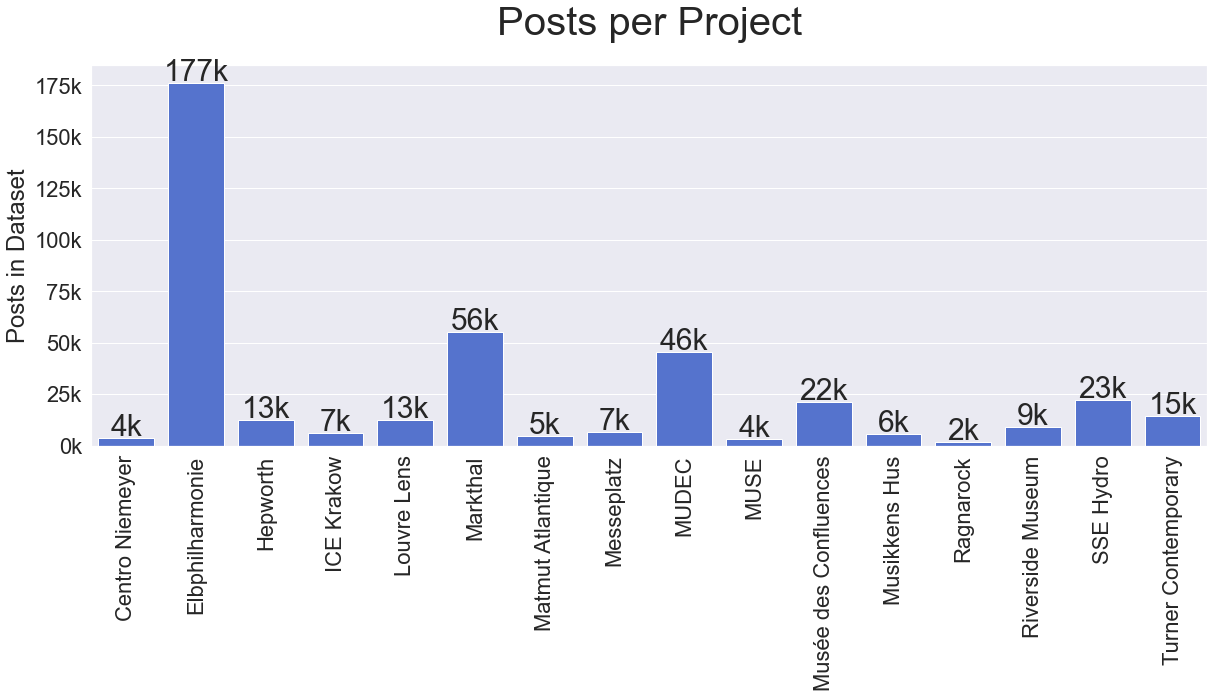

In [68]:
import matplotlib.ticker as ticker

sns.set(rc={'figure.figsize': (20, 7)})
sns.set(font_scale=2)

projects = list(data.keys())
ig_posts = []
ct_posts = []
for project in projects:
    res = data[project]
    ig_posts.append(len(res["df"]))
    city = res["df_city"]
    ct_posts.append(0 if city is None else len(city))

ax = sns.barplot(x=projects_trunc, y=ig_posts, color="royalblue")
y = [25000, 50000, 75000, 100000, 175000]


# set the y-axis tick labels using FuncFormatter
def y_fmt(y_val, tick_pos):
    return f"{int(np.ceil(y_val / 1000))}k"


ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_fmt))

for i, v in enumerate(ig_posts):
    ax.text(i, v + 1000, y_fmt(v, None), ha='center', fontsize=30)

plt.xticks(rotation=90)
plt.title("Posts per Project", fontsize=40, pad=30)
plt.ylabel("Posts in Dataset")
""

## Seasonal Behavior

Text(0.5, 1.0, 'Post Frequency by Month of the Year')

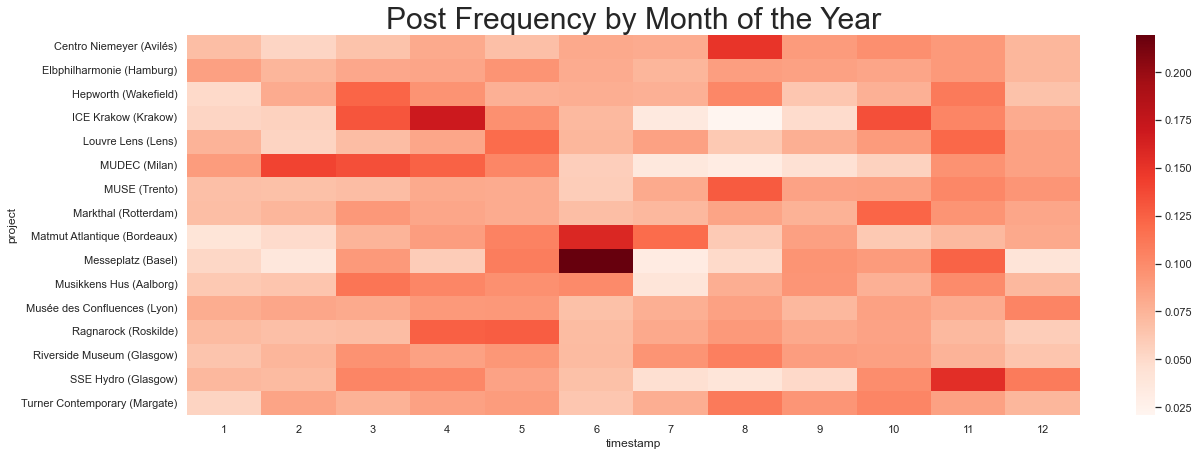

In [69]:
def cal(num, abbr=True):
    return calendar.month_abbr[num] if abbr else calendar.month_name[num]

by_project_month = df_all.groupby(["project", df_all.index.month])["id"].count().to_frame().reset_index()
data_abs = by_project_month.pivot(index="project", columns="timestamp", values="id")
data_rel = data_abs.divide(data_abs.sum(axis=1), axis=0)  # get relative frequency
sns.set(rc={'figure.figsize': (20, 7)})
sns.heatmap(data_rel, cmap="Reds")
plt.title("Post Frequency by Month of the Year", fontsize=30)

### Posts by month of the year

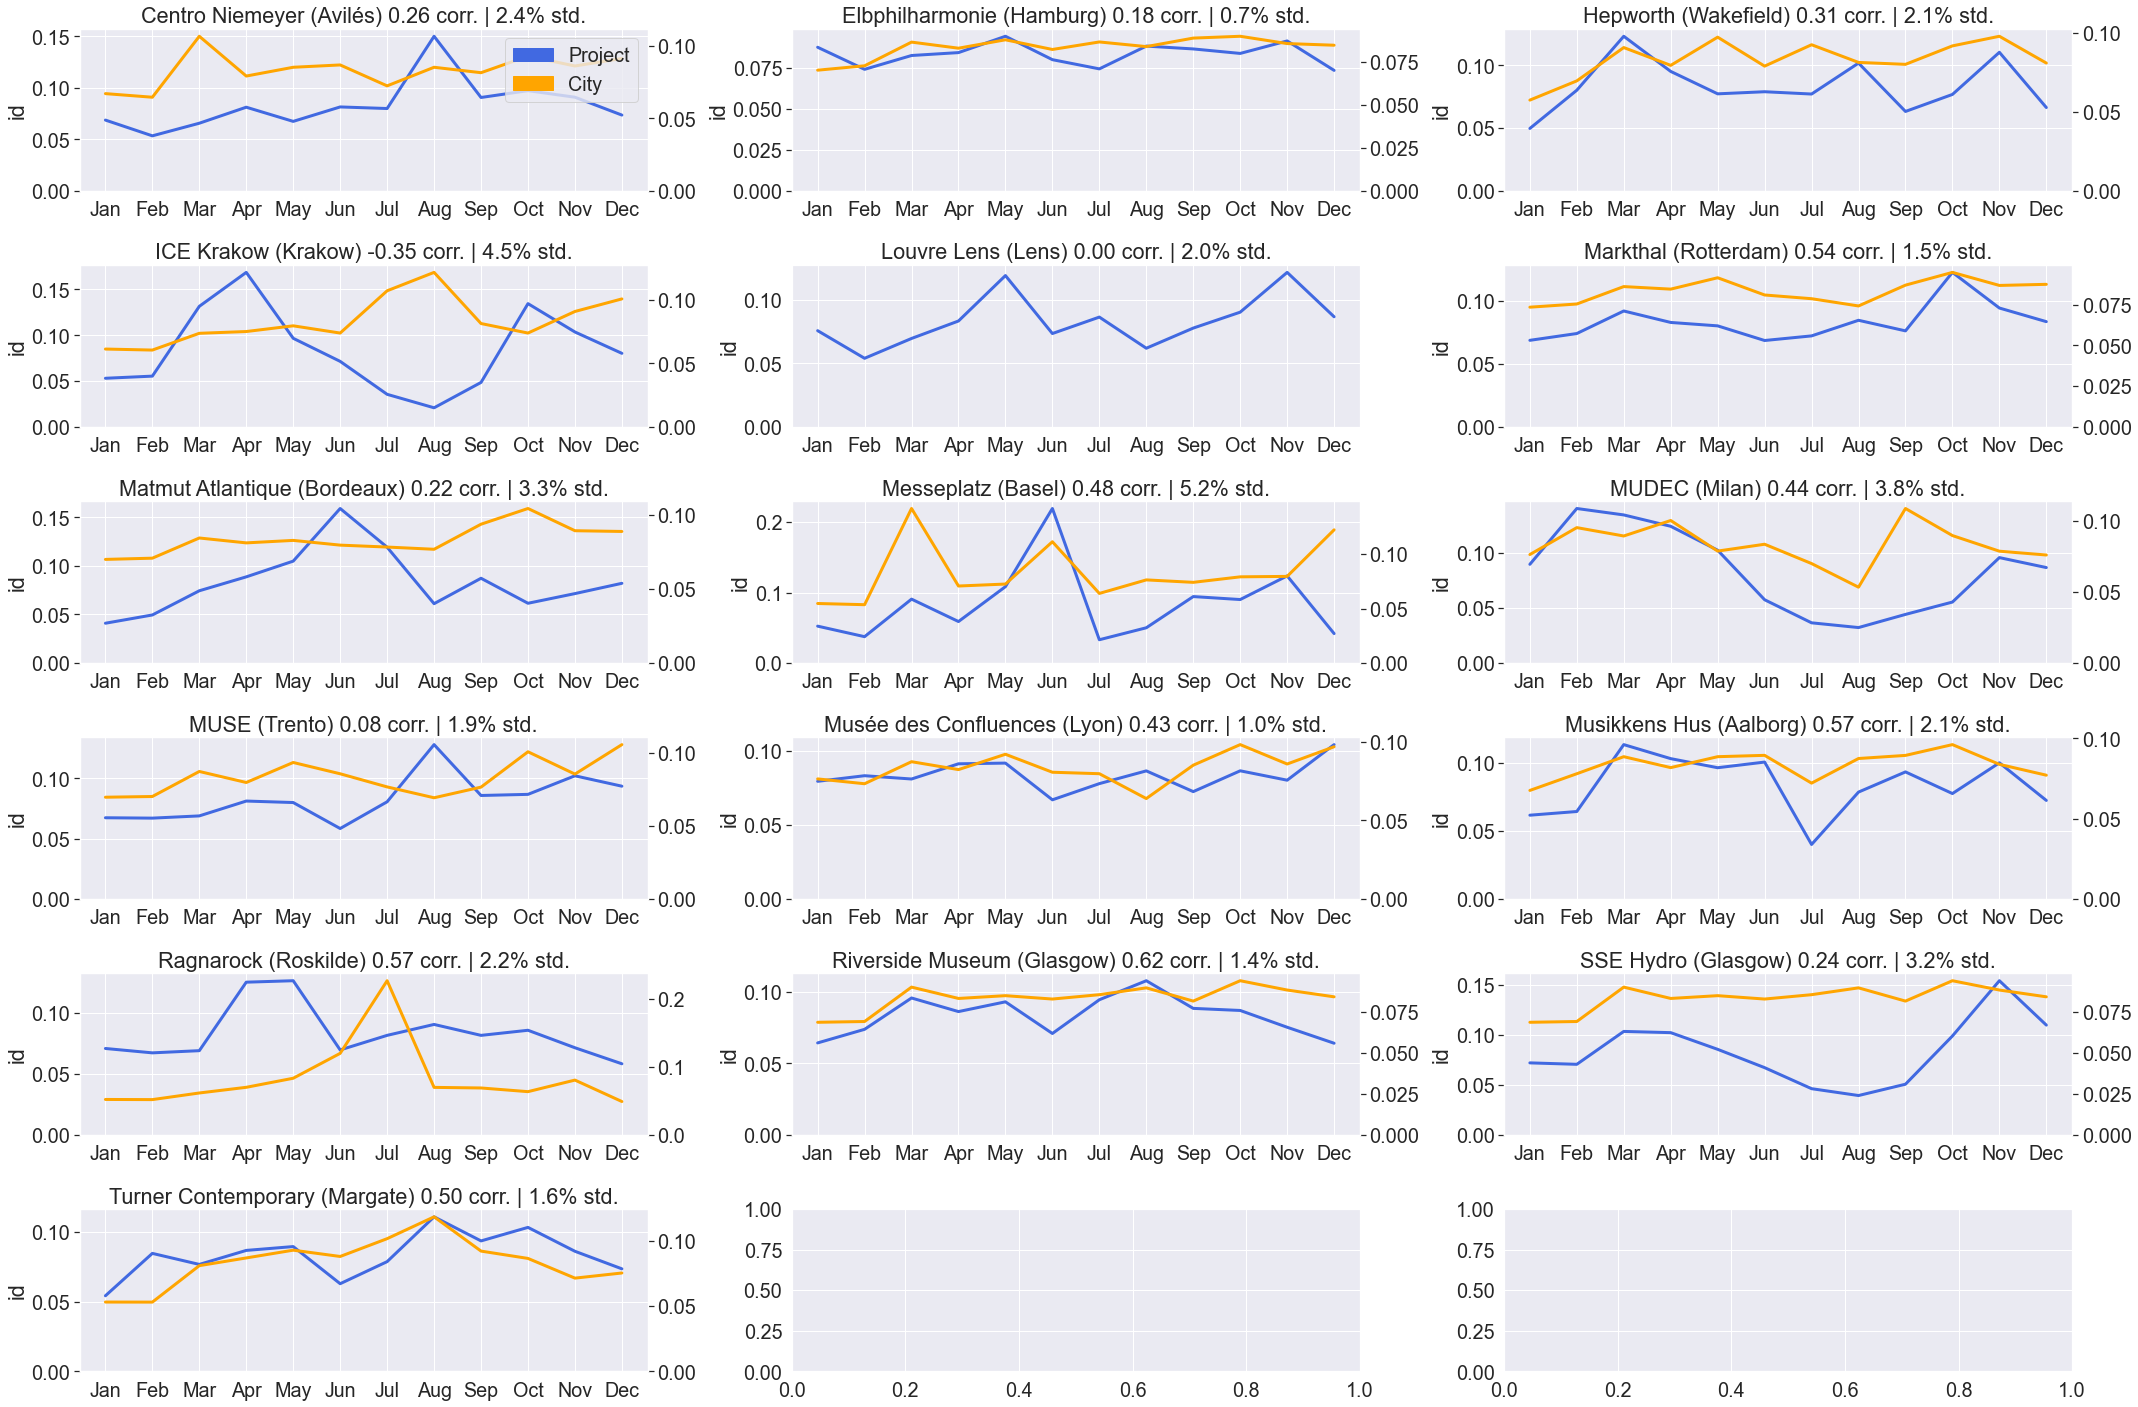

In [72]:
reset_layout()
n_cols = 3
fig, axs = plt.subplots(6, n_cols, figsize=[30, 20])
for i, project in enumerate(data):
    res = data[project]
    df = res["df"]
    df_city = res["df_city"]

    m = df.groupby(df.index.month)["id"].count()
    # normalize data to 1 (i.e. each month shows % if posts across all months
    m /= sum(m)
    ax = axs[int(i / n_cols), i % n_cols]
    # force y-axis to start at 0 which doesn't happen automatically for some reason (important for comparing the curve shapes fairly!)
    ax.set_ylim([0, max(m) * 1.05])
    sns.lineplot(x=list(map(lambda i: cal(i), m.index)), y=m, color="royalblue", ax=ax, linewidth=3)
    # ax.set_title("{} - min to max month {:.1%}".format(df.name,min(m) / max(m)))
    if len(df_city) > 0:

        ax2 = ax.twinx()
        m_city = df_city.groupby(df_city.index.month)["URL"].count()
        m_city /= m_city.sum()
        line2 = sns.lineplot(x=list(map(lambda i: cal(i), m_city.index)), y=m_city, color="orange", ax=ax2,
                             linewidth=3)  #  label="city"
        ax2.set_ylabel("")
        ax2.set_ylim([0, max(m_city) * 1.05])
        # hide grid of the second plot to avoid overlapping grids
        ax2.grid(None)
        opening = pd.to_datetime(res["opening"])

        # calc correlation
        corr = m.corr(m_city, method="spearman")
    else:
        corr = 0
    ax.set_title("{} {:.2f} corr. | {:.1%} std.".format(df.name, corr, m.std()))

    if i == 0:
        # Manually create legend
        project_patch = mpatches.Patch(color='royalblue', label='Project')
        city_patch = mpatches.Patch(color='orange', label='City')
        plt.legend(handles=[project_patch, city_patch], loc="upper right")

plt.tight_layout()

**Results**
Not exactly sure what to do with this yet.
We can see strong seasonality of the event spaces (SSE, Messeplatz, ICE Krakow, Matmut Atlantique
  but some of the museums show strong seasonality as well (related to exhibitions?
-> no standalone results yet, rather keep these results in mind for analysis w.r.t events later

### Autocorrelation (ACF)
https://towardsdatascience.com/most-useful-python-functions-for-time-series-analysis-ed1a9cb3aa8b
    https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

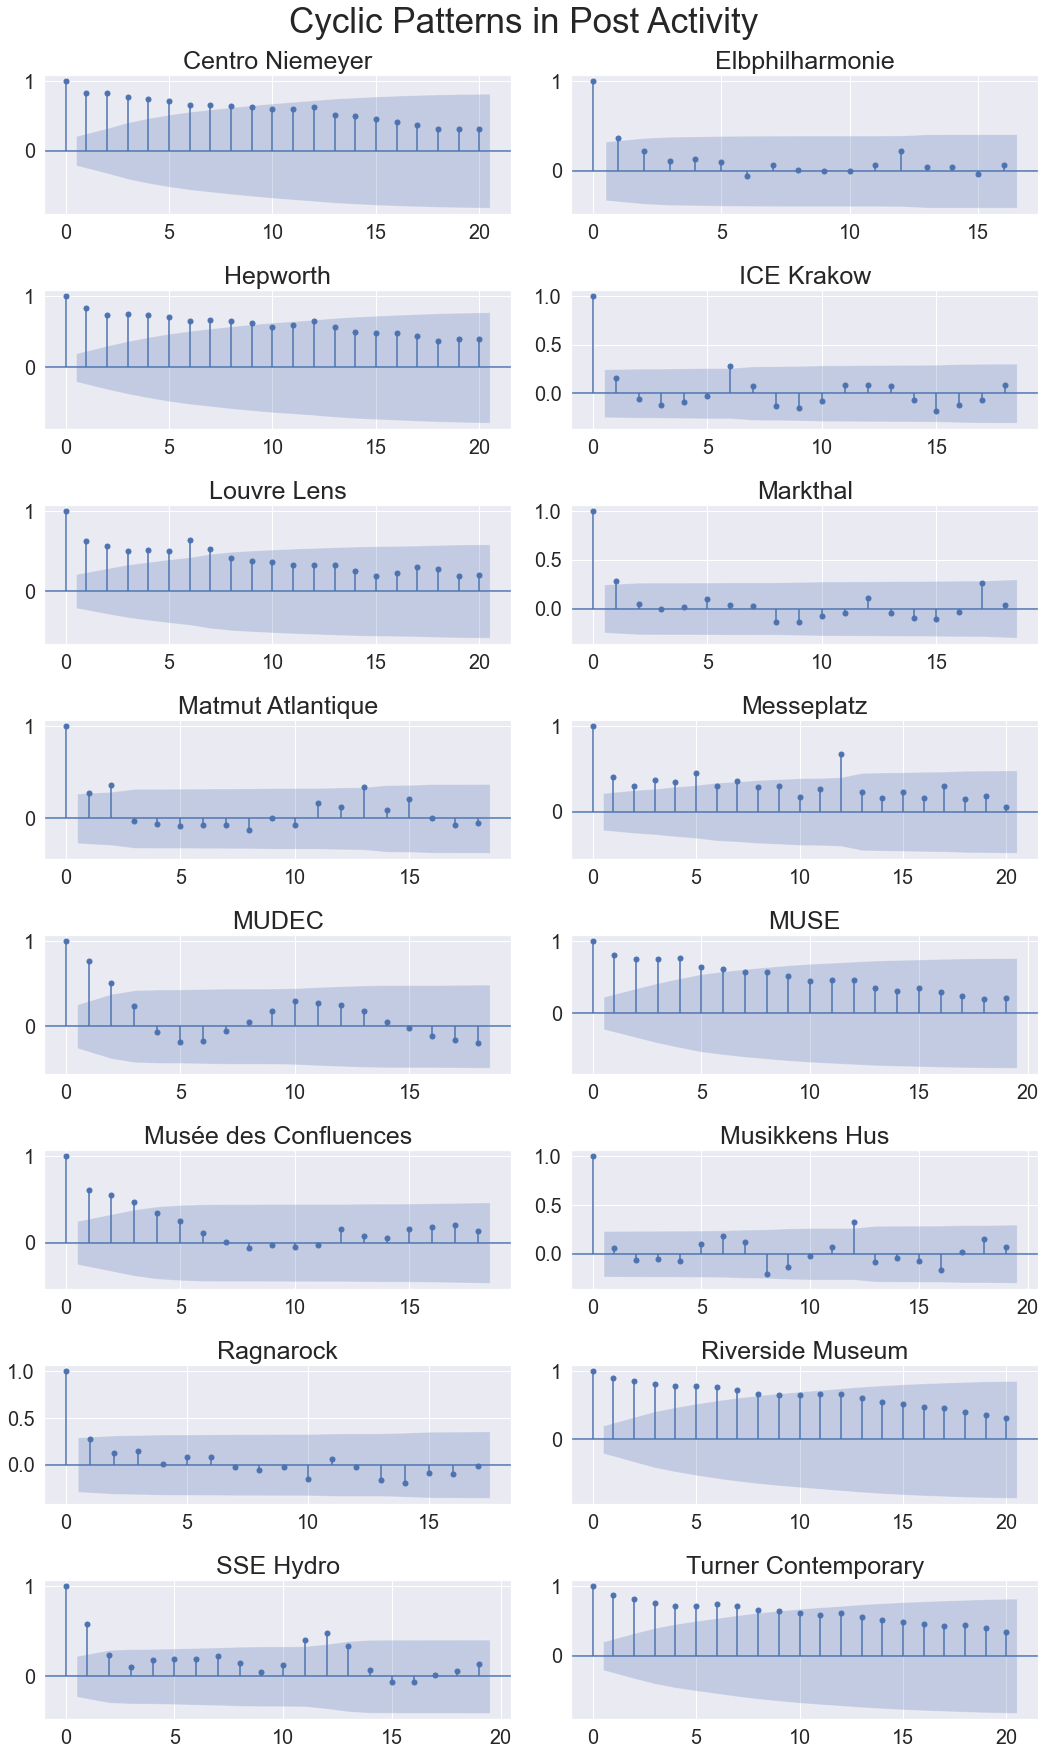

In [73]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(font_scale=1.8)

n_cols = 2
fig, axs = plt.subplots(8, n_cols, figsize=[15, 25])
freq = "M"
for i, project in enumerate(data):
    res = data[project]
    df = res["df"]
    df_city = res["df_city"]
    opening = pd.to_datetime(res["opening"])

    ax = axs[int(i / n_cols), i % n_cols]
    grouped_project = df.groupby(pd.Grouper(freq=freq))["id"].count()

    # only consider time from opening
    grouped_project_truncated = grouped_project[(grouped_project.index >= opening) & ~grouped_project.isna()]
    grouped_project_truncated.replace(np.inf, 0, inplace=True)

    acf_res = acf(grouped_project_truncated, nlags=50, fft=True)
    plot_acf(grouped_project_truncated, title=project, ax=ax)
    ax.set_title(project.split("(")[0].strip(), fontsize=25)
plt.suptitle("Cyclic Patterns in Post Activity", fontsize=35)
plt.tight_layout()

**Results**
- 12-month cycles on:
    - Matmut Atlantique (more like 13 months)
    - Messeplatz
    - SSE Hydro
- other cycles: MUDEC (10 months)


## Post activity over time

### Post activity as ridge plot (for fun)

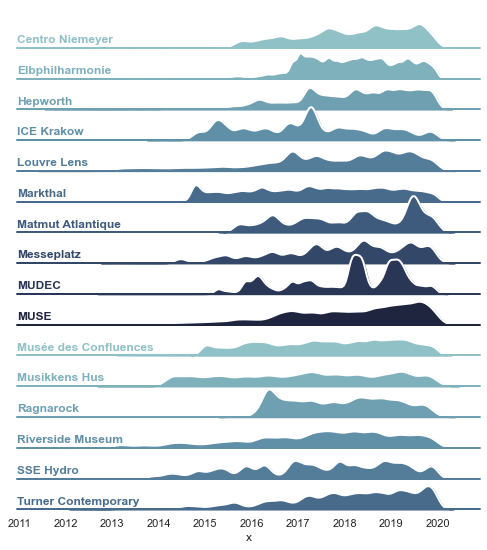

In [74]:
def ridgeplot(df, id_col, var_col):
    """
    :param df: dataframe with at least the colums id_col and time_col
    :param id_col: column with the values of the y-axis of the ridgeplot
    :param var_col: x-axis of the ridgeplot
    :return:
    """
    # https://seaborn.pydata.org/examples/kde_ridgeplot
    # Create long df with observations from all cases, then create 2-column df of [x,g] , where x=timestamp, g=building (x,g names are so that variable names in code below can stay the same)
    df_copy = df.copy()
    df_copy = df_copy.reset_index()[[id_col, var_col]].rename(columns={var_col: "x", id_col: "g"})

    # set minimalistic theme
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df_copy, row="g", hue="g", aspect=15, height=0.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "x")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # reset minimalistic theme
    reset_layout()

ridgeplot(df_all, id_col="project_trunc", var_col="timestamp")

### Project vs. City Posts +correlation

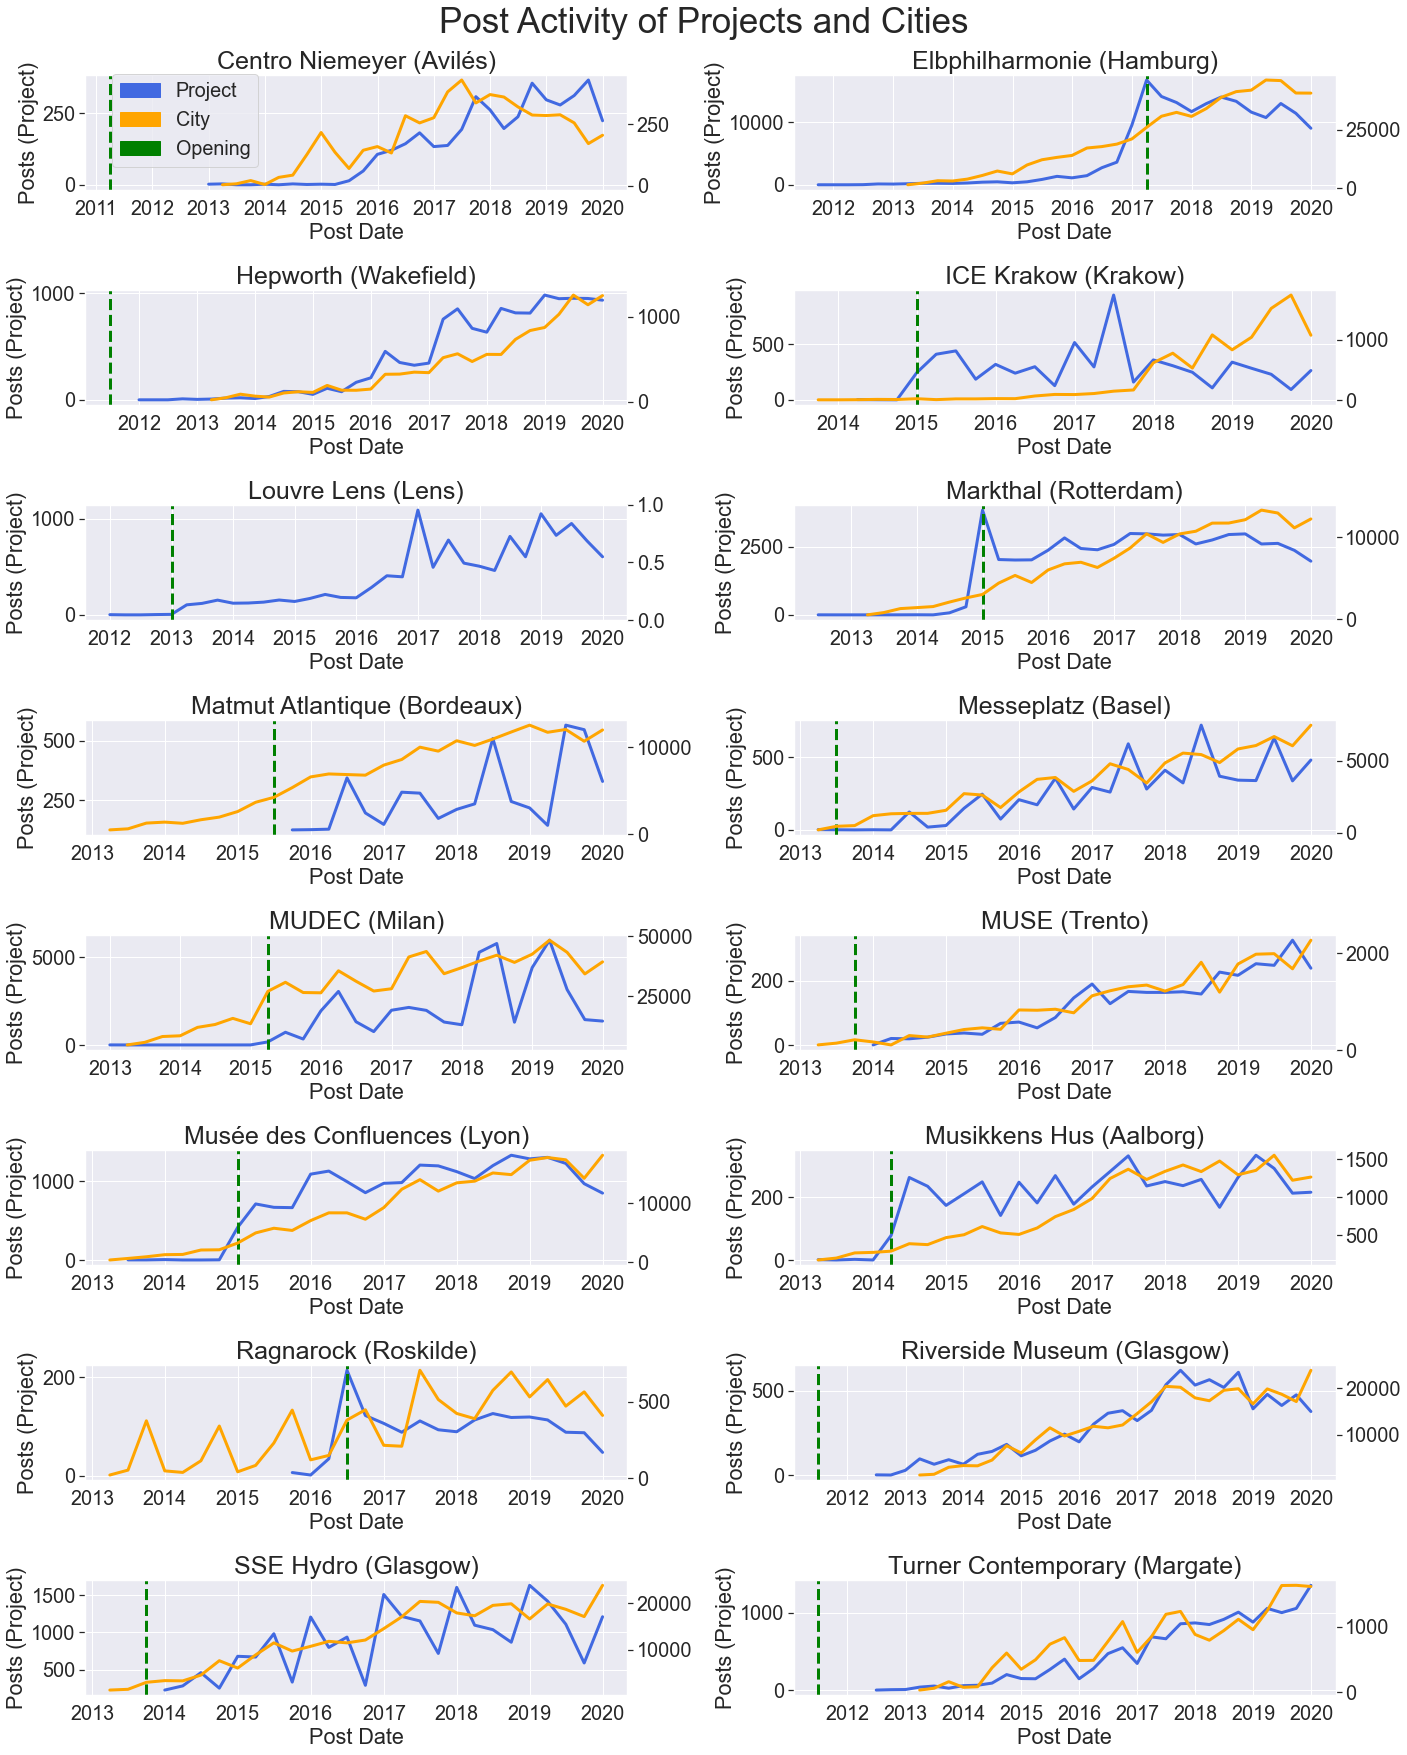

In [75]:
n_cols = 2
freq = "Q"
fig, axs = plt.subplots(8, n_cols, figsize=[20, 25])
for i, project in enumerate(data):

    # if project not in ["Markthal (Rotterdam)","Turner Contemporary"]

    res = data[project]
    df = res["df"]
    df_city = res["df_city"]
    offset_lookup = {"Q": QuarterEnd(0), "Y": YearEnd(0)}
    opening = pd.to_datetime(res["opening"]) + offset_lookup[freq]
    ax = axs[int(i / n_cols), i % n_cols]
    ax.set_xlabel("Post Date")
    ax.set_ylabel("Posts (Project)")
    # Plot the project data
    grouped_project = df.groupby(pd.Grouper(freq=freq))["id"].count()
    line1 = sns.lineplot(data=grouped_project, ax=ax, linewidth=3, color="royalblue")  # , label="project"
    # Plot the city data
    if df_city is not None:
        ax2 = ax.twinx()
        grouped_city = df_city.groupby(pd.Grouper(freq=freq))["URL"].count()
        line2 = sns.lineplot(data=grouped_city, ax=ax2, linewidth=3, color="orange")  #  label="city"
        ax2.set_ylabel("")
        # hide grid of the second plot to avoid overlapping grids
        ax2.grid(None)

        # only consider posts from opening onwards
        grouped_project_truncated = grouped_project[grouped_project.index >= opening]
        grouped_city_truncated = grouped_city[grouped_city.index >= opening]
        corr = grouped_project_truncated.to_frame().join(grouped_city_truncated.to_frame(), how="inner").corr(
            method="spearman").iloc[
            0, 1]
    else:
        corr = 0

    line4 = ax.axvline(x=opening, color='green', linestyle="--", label='Opening: {}'.format(res["opening"]),
                       linewidth=3)

    ax.set_title("{}".format(project), fontsize=25)

    # Manually create legend
    if i == 0:
        project_patch = mpatches.Patch(color='royalblue', label='Project')
        city_patch = mpatches.Patch(color='orange', label='City')
        opening_patch = mpatches.Patch(color='green', label='Opening')
        # fitted_patch = mpatches.Patch(color='cornflowerblue', label='Fitted Line')
        plt.legend(handles=[project_patch, city_patch, opening_patch], loc=[0.05, 0.2])
plt.suptitle("Post Activity of Projects and Cities", fontsize=35)
plt.tight_layout()

Note: city data (from Crowdtangle) is only available from Feb 4 2013 (apparently CT only keeps data from exactly 10 years and I scraped the data on Feb 4th 2023)

## Project w.r.t. Visitor Numbers

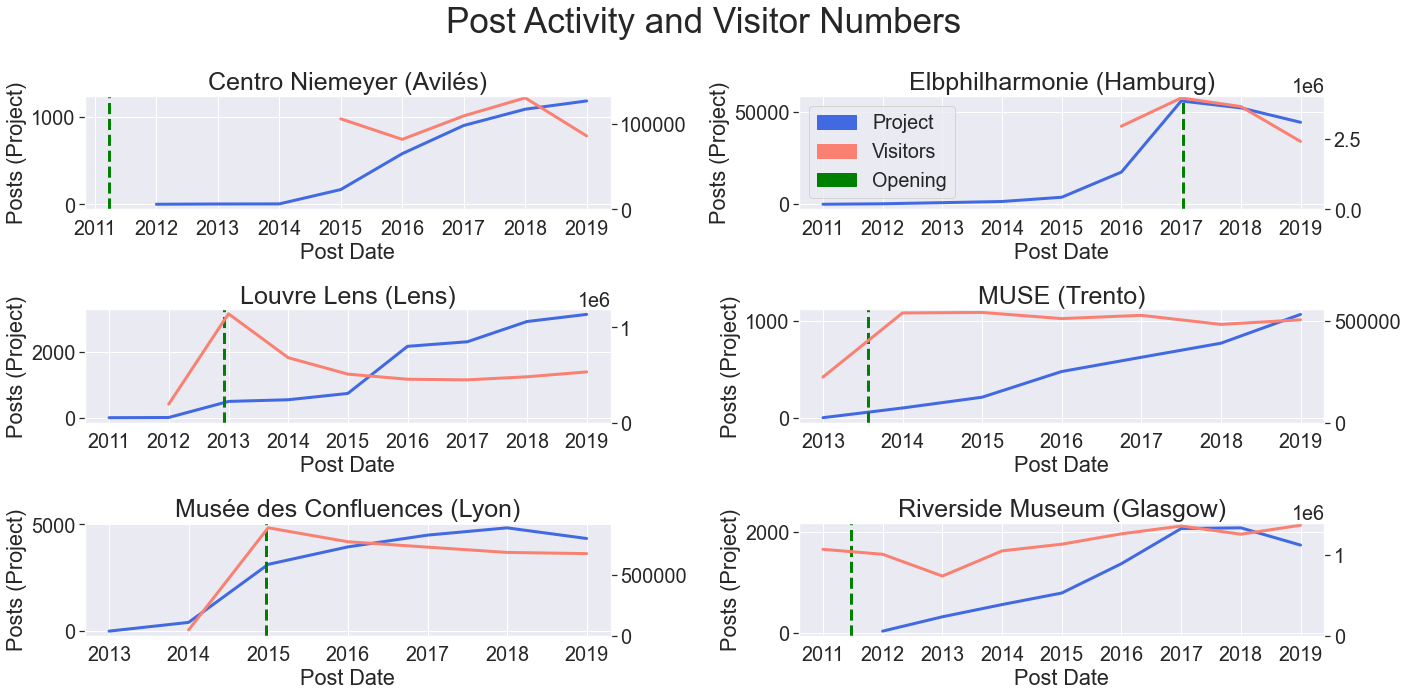

In [76]:
n_cols = 2
freq = "Y"
fig, axs = plt.subplots(3, n_cols, figsize=[20, 10])
i = 0
for project, res in data.items():
    df = res["df"]
    offset_lookup = {"Q": QuarterEnd(0), "Y": YearEnd(0)}
    opening = pd.to_datetime(res["opening"])  # + offset_lookup[freq]

    if res["visitors"] is not None:
        ax = axs[int(i / n_cols), i % n_cols]

        grouped_project = df.groupby(pd.Grouper(freq=freq))["id"].count()
        grouped_project.index = pd.to_datetime(grouped_project.index.year,
                                               format='%Y')  # grouping sets a datetime for last dy of year, we want first day of the year to compare with visitor numbers
        line1 = sns.lineplot(data=grouped_project, ax=ax, linewidth=3, color="royalblue")  # , label="project"

        ax.set_xlabel("Post Date")
        ax.set_ylabel("Posts (Project)")

        ax2 = ax.twinx()

        visitors = res["visitors"]
        y = "Espectadores" if project == "Centro Niemeyer (Avilés)" else "Visitors"
        line2 = sns.lineplot(data=visitors, x="Year", y=y, ax=ax2, linewidth=3, color="salmon")  # , label="project"

        ax2.grid(None)
        ax2.set_ylabel("")
        ax2.set_ylim(0, None)

        line3 = ax.axvline(x=opening, color='green', linestyle="--", label='Opening: {}'.format(res["opening"]),
                           linewidth=3)
        ax.set_title("{}".format(project), fontsize=25)  # {:.2f} corr.

        # Manually create legend
        if i == 1:
            project_patch = mpatches.Patch(color='royalblue', label='Project')
            visitors_patch = mpatches.Patch(color='salmon', label='Visitors')
            opening_patch = mpatches.Patch(color='green', label='Opening')
            # fitted_patch = mpatches.Patch(color='cornflowerblue', label='Fitted Line')
            plt.legend(handles=[project_patch, visitors_patch, opening_patch])  # loc=[0.05,0.2]

        i += 1
plt.suptitle("Post Activity and Visitor Numbers", fontsize=35)
plt.tight_layout()

### Project w.r.t. city

No handles with labels found to put in legend.


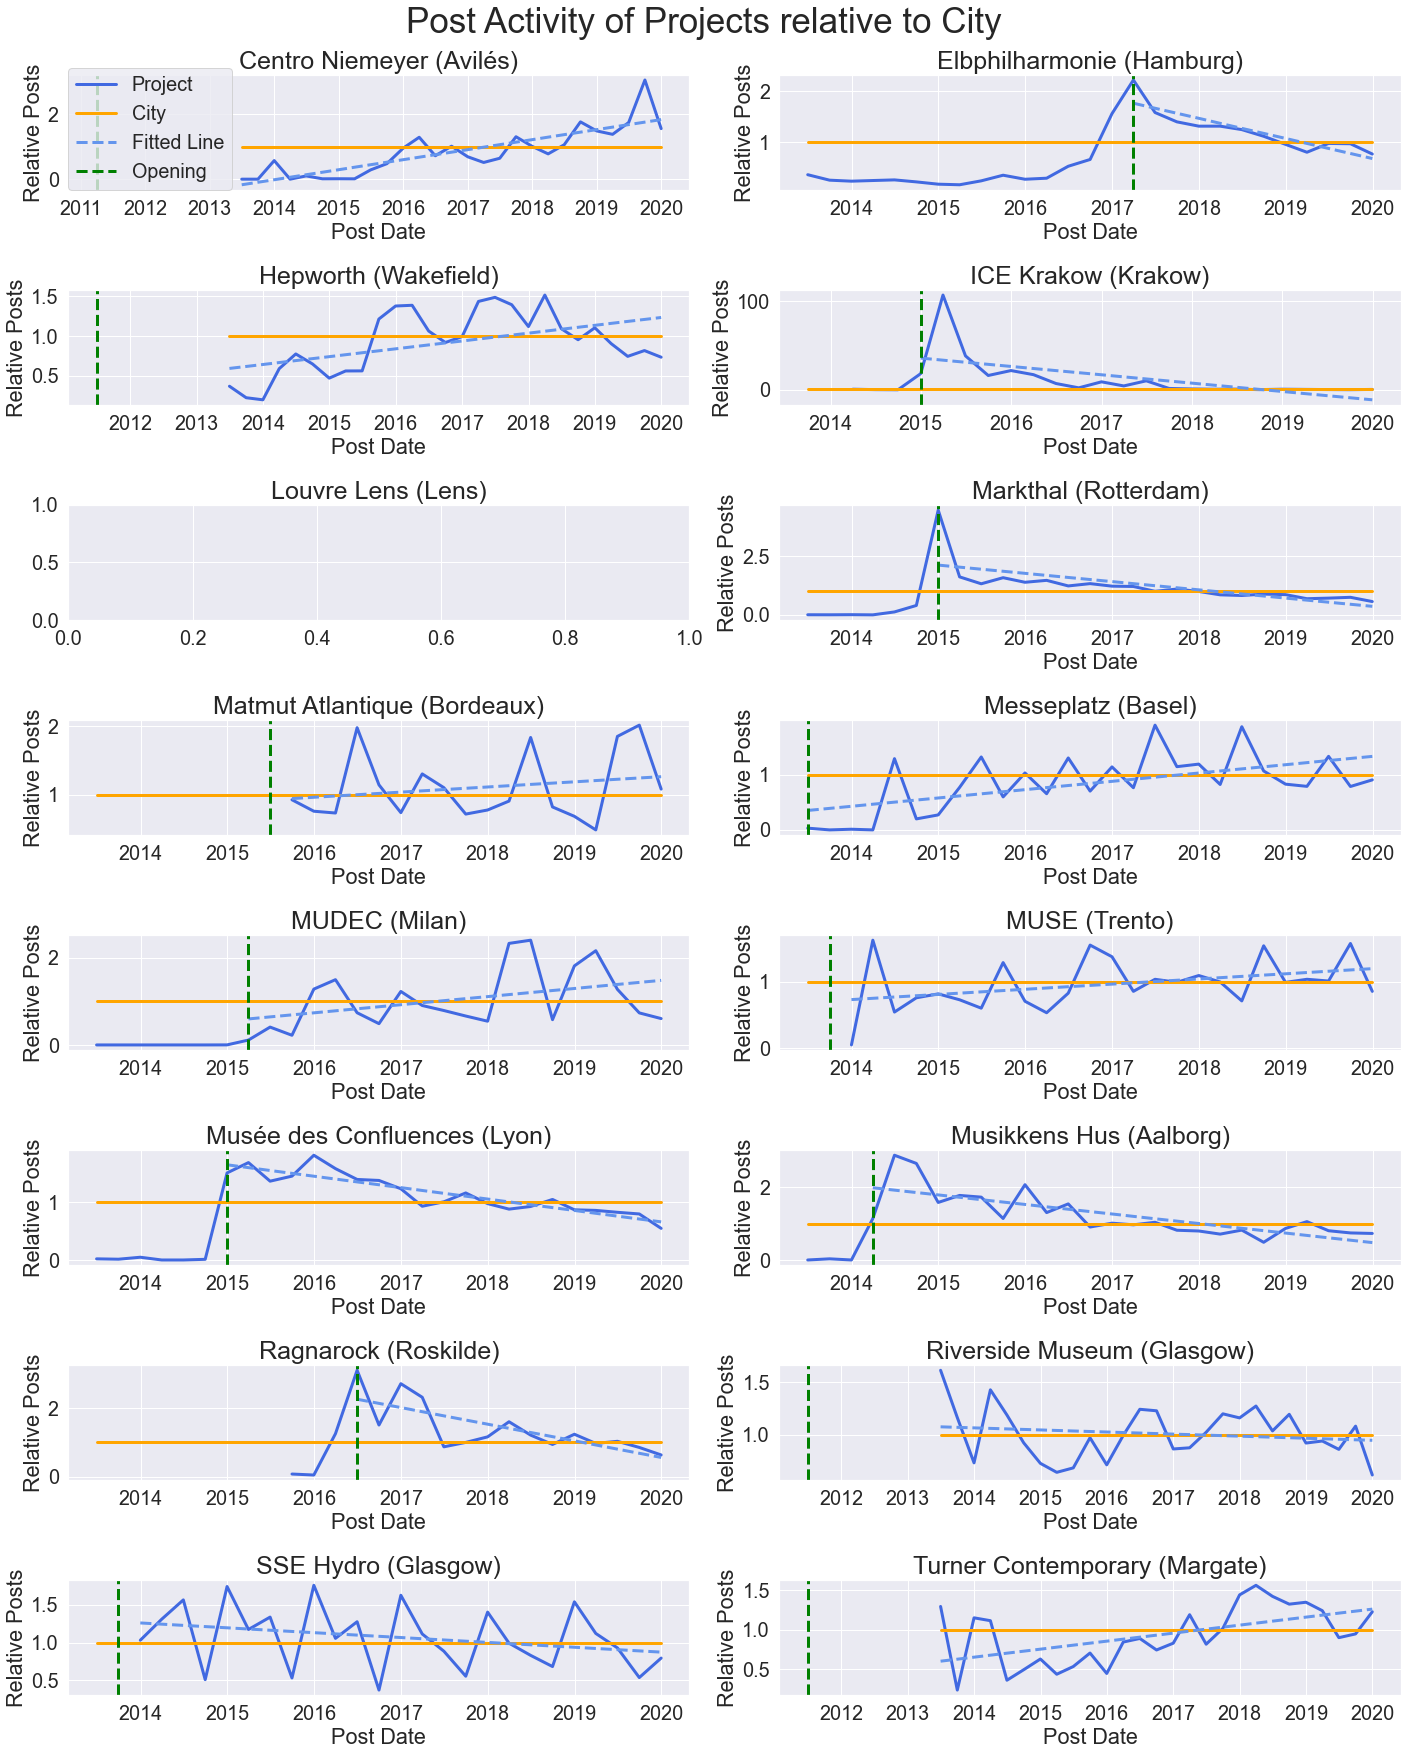

In [77]:
def project_vs_city(freq, fit_line=True):
    # lay ctiy curve flat, normalize both to relative
    n_cols = 2
    fig, axs = plt.subplots(8, n_cols, figsize=[20, 25])
    for i, project in enumerate(data):

        res = data[project]
        df = res["df"]
        df_city = res["df_city"]
        # shift opening to nearest quarter so it matches up with the data that will be grouped by quarter
        offset_lookup = {"Q": QuarterEnd(0), "Y": YearEnd(0)}
        opening = pd.to_datetime(res["opening"]) + offset_lookup[freq]
        ax = axs[int(i / n_cols), i % n_cols]
        if len(df_city)>0:
            ax.set_xlabel("Post Date")
            ax.set_ylabel("Relative Posts")
            # Plot the project data
            grouped_project = df.groupby(pd.Grouper(freq=freq))["id"].count()
            grouped_project_rel = grouped_project / grouped_project.sum()
            grouped_city = df_city.groupby(pd.Grouper(freq=freq))["URL"].count()
            # start data from where city data is available for a full quarter (first quarter of 2013 only has ~25 days worth of data in all CT datasets)
            grouped_city = grouped_city[(grouped_city.index > pd.to_datetime("2013-03-31"))]  #  & (grouped_city >= 50)
            grouped_city_rel = grouped_city / grouped_city.sum()
            grouped_project_squish = grouped_project_rel.divide(grouped_city_rel, axis=0)
            grouped_city_sqiush = grouped_city_rel.divide(grouped_city_rel, axis=0)

            line1 = sns.lineplot(data=grouped_project_squish, ax=ax, linewidth=3, color="royalblue", label="Project")
            line2 = sns.lineplot(data=grouped_city_sqiush, ax=ax, linewidth=3, color="orange",
                                 label="City")  #  label="city"

            if fit_line:
                # Fit a line to the posts from the opening onward and where city cata is available
                grouped_project_squish_truncated = grouped_project_squish[
                    (grouped_project_squish.index >= opening) & ~grouped_project_squish.isna()]
                # shift the dates if the grouping bins to the ind the middle of the bin rather than the end
                # grouped_project_squish_truncated.index = grouped_project_squish_truncated.index.shift(-45, freq="D")
                a = np.array(grouped_project_squish_truncated)
                slope, intercept = np.polyfit(range(len(a)), a, 1)
                fitted_lined = [slope * x + intercept for x in range(len(a))]
                line3 = sns.lineplot(x=grouped_project_squish_truncated.index, linestyle="--", y=fitted_lined, ax=ax,
                                     linewidth=3,
                                     color="cornflowerblue", label="Fitted Line")

            # ad line for the opening
            line4 = ax.axvline(x=opening, color='green', linestyle="--", label="Opening", linewidth=3)
        else:
            slope = 0

        ax.set_title(project, fontsize=25)
        ax.legend(loc=(0, 0))
        if i != 0:
            ax.get_legend().remove()
    plt.suptitle("Post Activity of Projects relative to City", fontsize=35)
    plt.tight_layout()


project_vs_city("Q")

Notes:
- data is grpuped by quarter, the position of the auarter ont he x axis is the last day of the qaurter
- opening is shown on last day of the quarter rather than the actual data to make it match up visually with the plot

**Baseline assumption:** a project has a fixed % of the city's posts every quarter. This happens if the blue line is completely flat at y=1 like the orange line
Blue line > orange curve (y=1): more posts than expected: Project got disproportionally more posts than city. E.g. 1.5 = project got 1.5x more posts than 'expected' just by how many posts there are for the city during that time
Blue line < orange curve (y=1): less posts than expected

**What this tells us:**
- which projects are getting more or less poopular over time w.r.t their city (slope of the fitted curve)
- when did events at the project happen that lead to a disproportionate number of posts of the project (compared to the city)

**This chart is accounting for:**
- the overall growth of the city on Instagram
- any seasonality of the city

**Caution: low data:**
- Take the ICE Krakow spike with a grain of salt because there was only 6 posts for Krakow (on Crowtangle) in the first quarter of 2015
  also if we take out the low data posts for Krakow we can see tht in 2018 and 19 the line project completely matches up with the city line
- If we require a quarter for the city to have at least 50 posts be considered as a data point the project fitted line has now an upwards trend
- all other case studies have sufficient data (>=50 posts per quarter) and the graphs don't change at all

Note: if showing this visualize how this chart comes to be: i.e. take regular plot and rotate+flatten orange curve so that it's a horizontal line

Toy example to show that there is high correlation when a city shows steady growth and a project receives no posts before the inauguration and steady posts after the inauguration even though intuitively these behaviors are very different.
Noise is added from normal distribution
This also shows that some minor spikes are always to be expected due to statistical fluctiations. We rather want to pay attention to the major spikes.

Correlation: 0.86


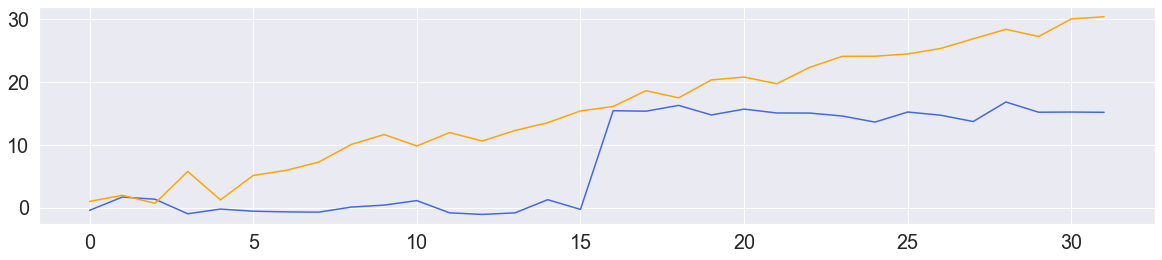

In [78]:
series1 = np.array([0] * 16 + [15] * 16) + np.random.normal(size=32)
series2 = np.array(list(range(0, 32))) + np.random.normal(size=32)

sns.lineplot(x=range(0, 32), y=series1, color="royalblue")
sns.lineplot(x=range(0, 32), y=series2, color="orange")
print("Correlation: {}".format(np.corrcoef(series1, series2)[0][1].round(2)))

## Explaining spikes in post activity

In [79]:
def plot_post_activity_slider(df, freq="W", id_col="id", line_dates=()):
    # plotly
    # line_dates: iterable of [date, color]
    y = df.groupby(pd.Grouper(freq=freq)).count()[id_col]
    fig = px.line(x=y.index, y=y, title=df.name)
    fig.update_xaxes(rangeslider_visible=True)
    for line_date, color in line_dates:
        fig.add_vline(x=line_date, line_width=2, line_color=color)  #  line_dash="dash"
    fig.show()


def plot_post_activity(df, freq="W", id_col="id", line_dates=(), title=None, title_fontsize=25):
    # seaborn
    grp = df.groupby(pd.Grouper(freq=freq))[id_col].count()
    ax = sns.lineplot(x=grp.index, y=grp, linewidth=3, color="royalblue", label="Post Activity")
    for i, (line_date, color) in enumerate(line_dates):
        label = "Peak" if i == 0 else None
        ax.axvline(x=line_date, color=color, linewidth=3, linestyle="--", label=label)
    if title is not None:
        plt.title(title, fontsize=title_fontsize, pad=10)
    plt.xlabel("Post Date")
    plt.ylabel("Posts")
    plt.legend()
    plt.show()


def get_spikes(df, freq="W", window_size=9, threshold=1.5, min_posts=20, id_col="id", aggregate="mean"):
    # Parameters found by: tuning until spikes in post activity charts manual inspection matched with the detected spikes
    # default: rolling window of 9 weeks (2 months) and 1.66 threshold which is equivalent to: the spike has to be 2x as high as the mean posts in the window
    # min-posts=20 to filter out weeks with very low number of posts, i.e. not enough data
    grouped = df.groupby(pd.Grouper(freq=freq)).count()[id_col]
    rolling = grouped.rolling(window=window_size, center=True)
    if aggregate == "mean":
        rolling_agg = rolling.mean()
    elif aggregate == "median":
        rolling_agg = rolling.median()
    else:
        raise NotImplementedError
    tmp = pd.DataFrame(data={"weekly_posts": grouped, "rolling_posts": rolling_agg})
    tmp["ratio"] = tmp["weekly_posts"] / tmp["rolling_posts"]
    return tmp[(tmp["ratio"] >= threshold) & (tmp["weekly_posts"] > min_posts)]


def get_spike_weeks(df):
    return get_spikes(df, freq="W", window_size=9, threshold=1.5, min_posts=20, id_col="id", aggregate="mean")


def get_spike_days(df):
    return get_spikes(df, freq="D", window_size=14, threshold=2, min_posts=10, id_col="id", aggregate="mean")

### Week spikes

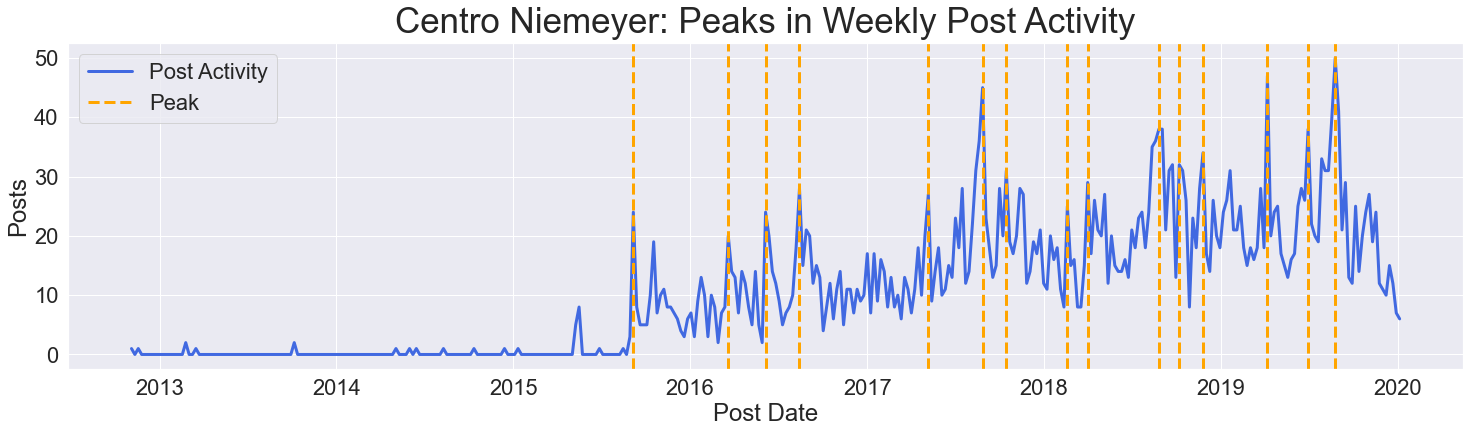

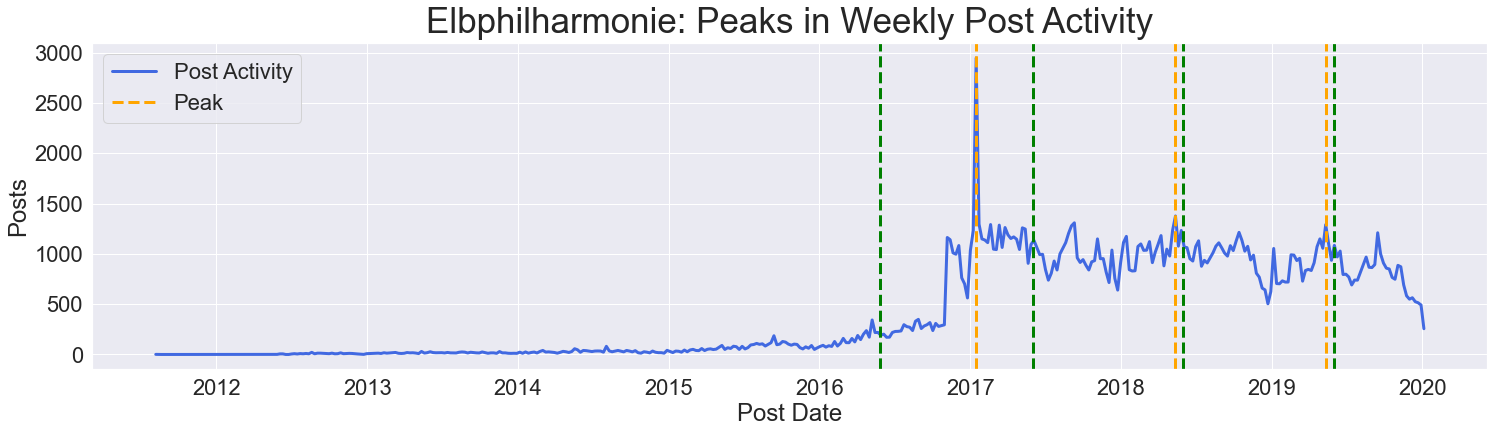

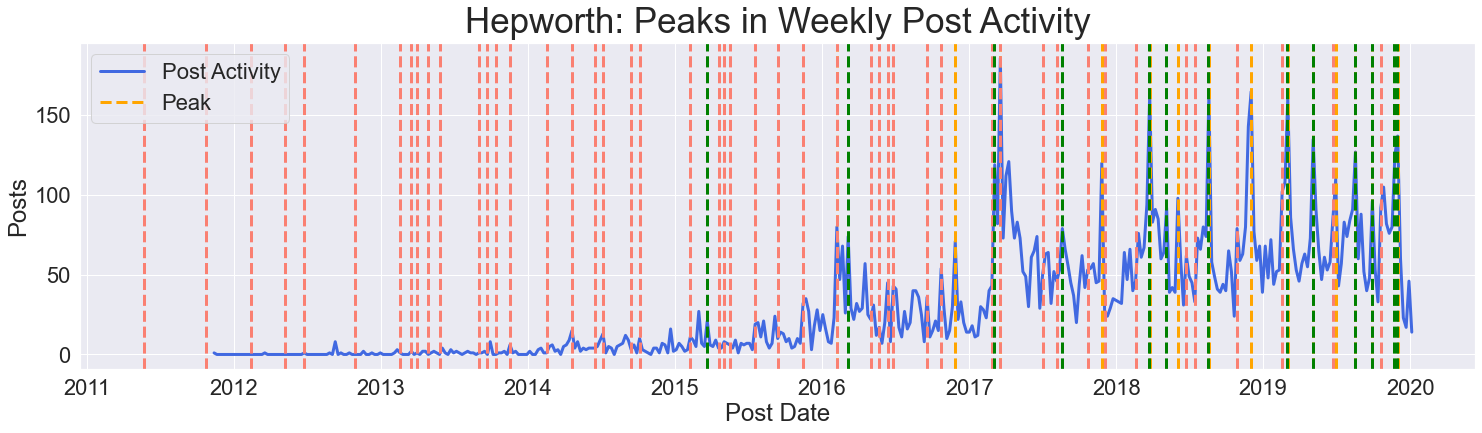

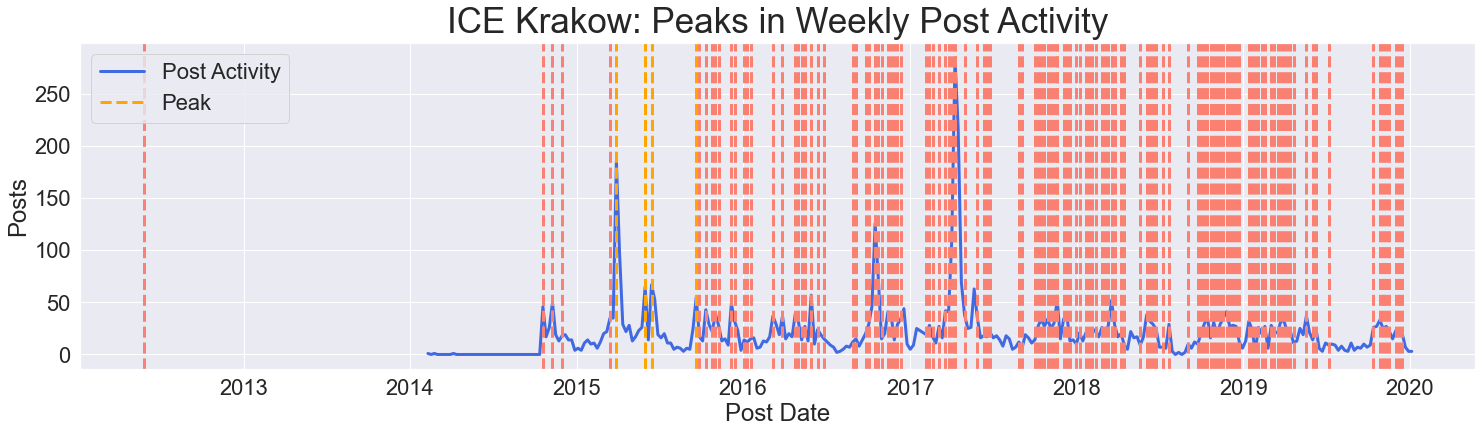

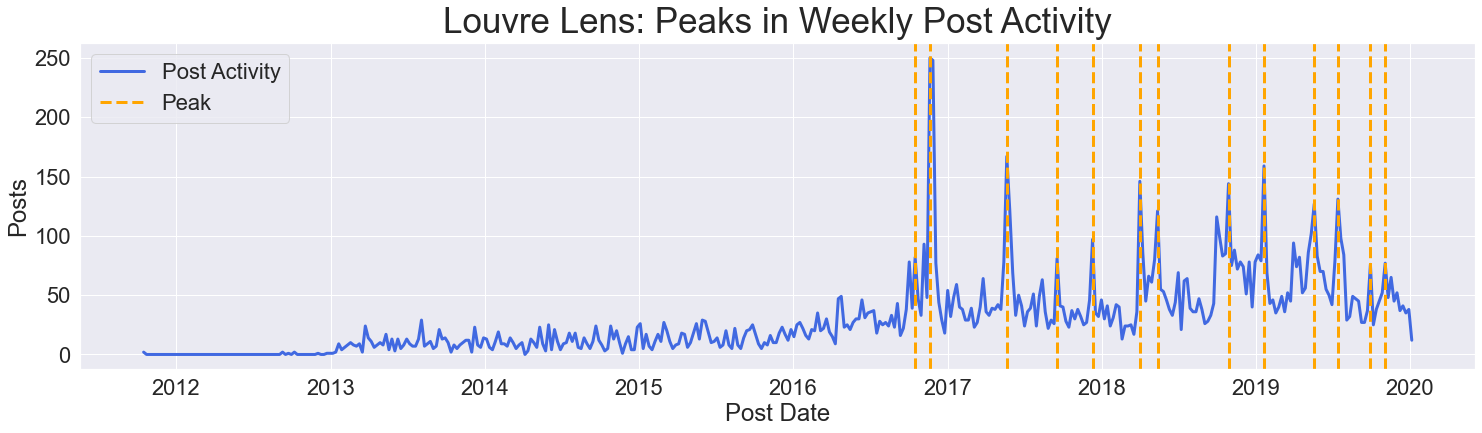

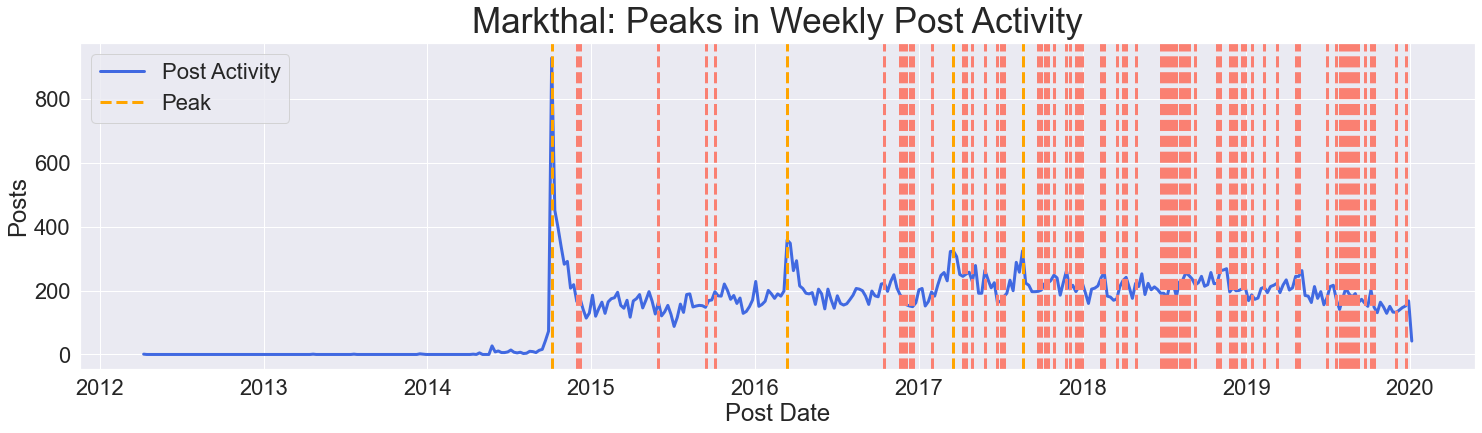

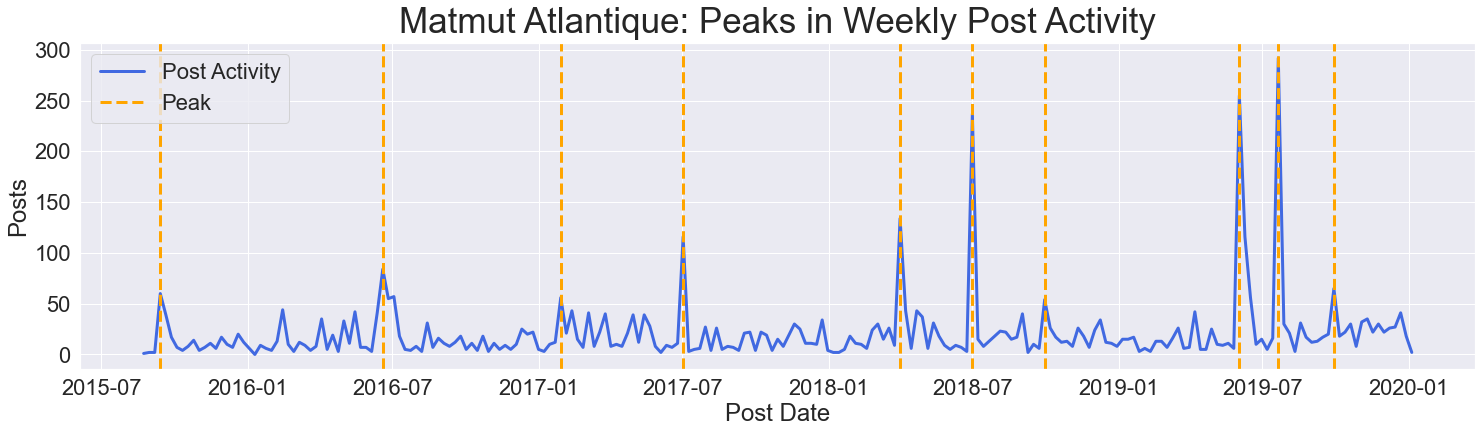

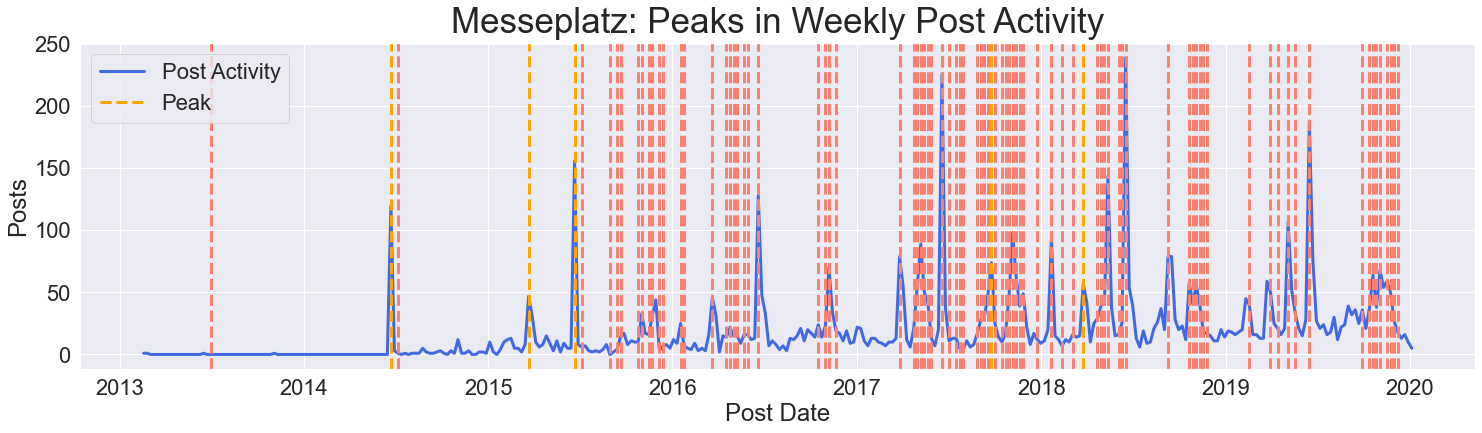

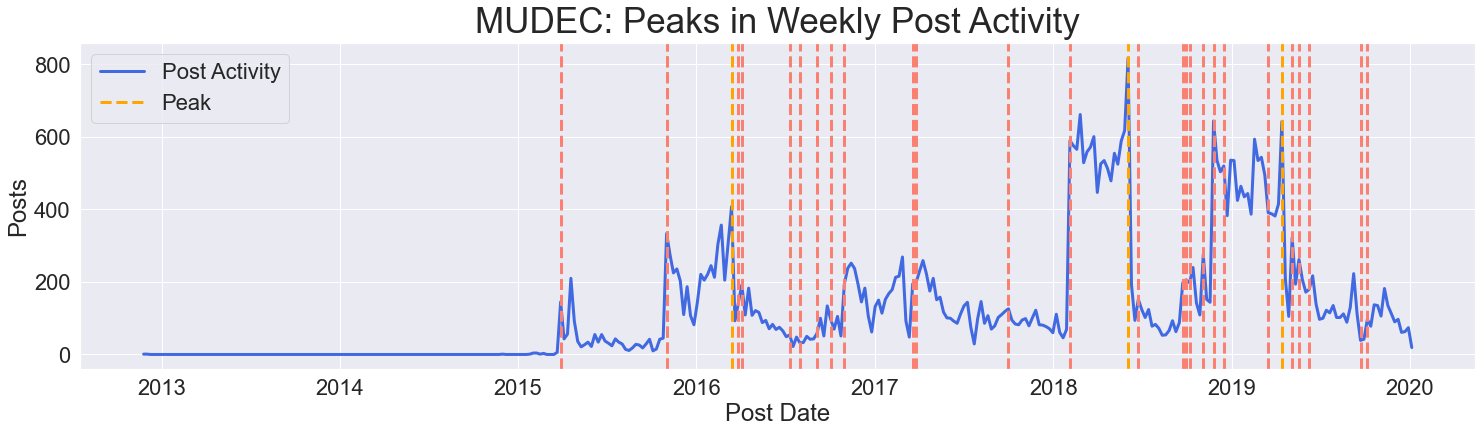

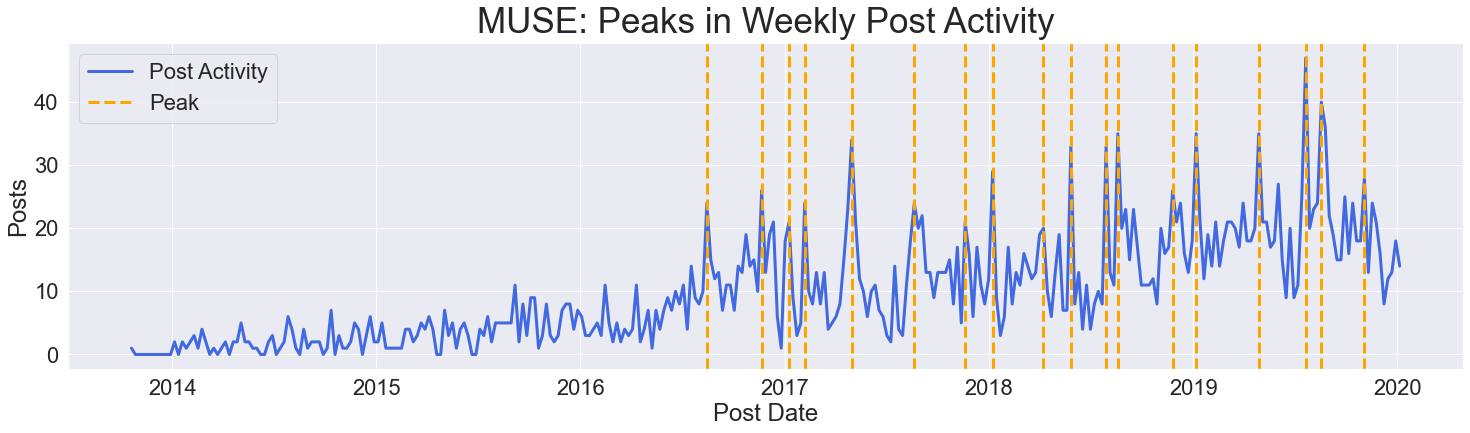

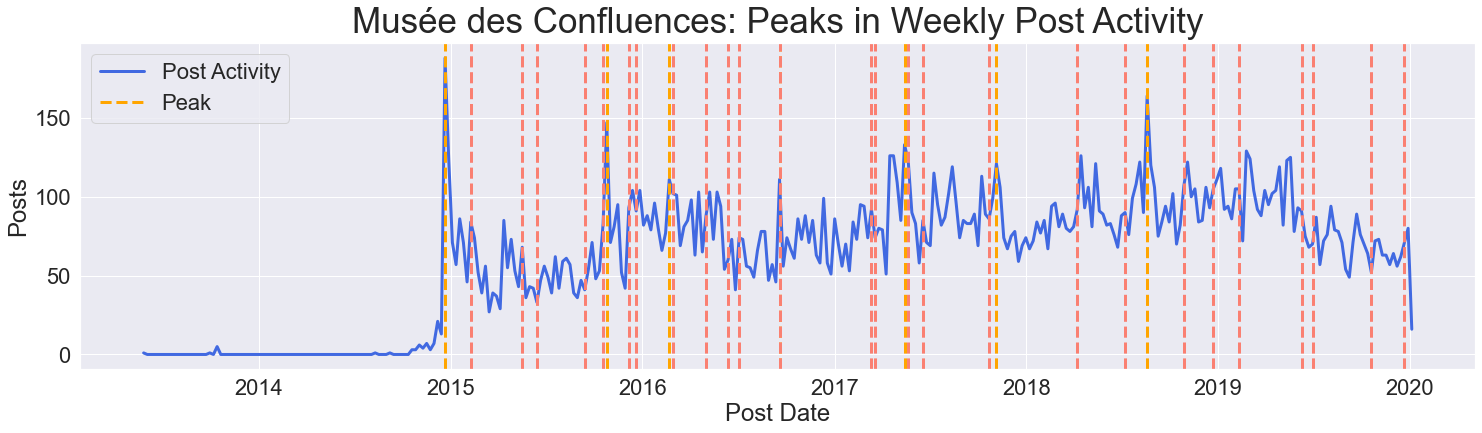

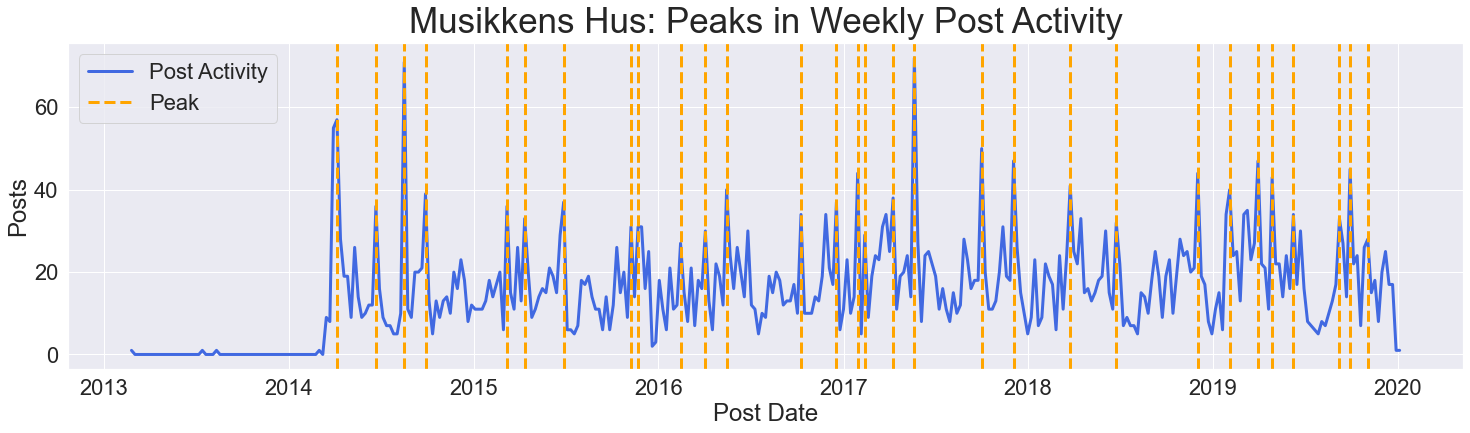

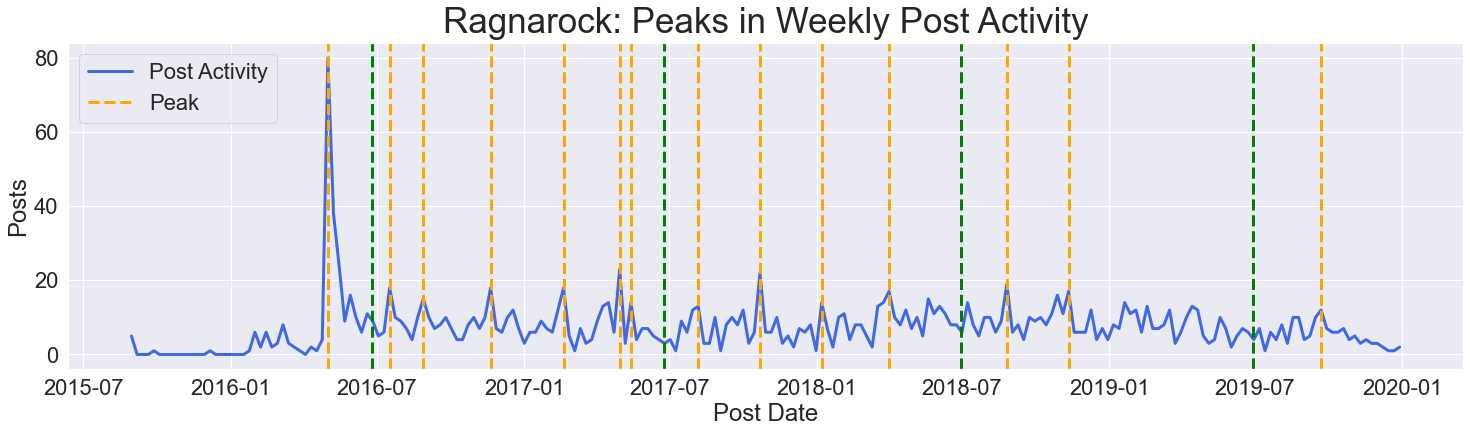

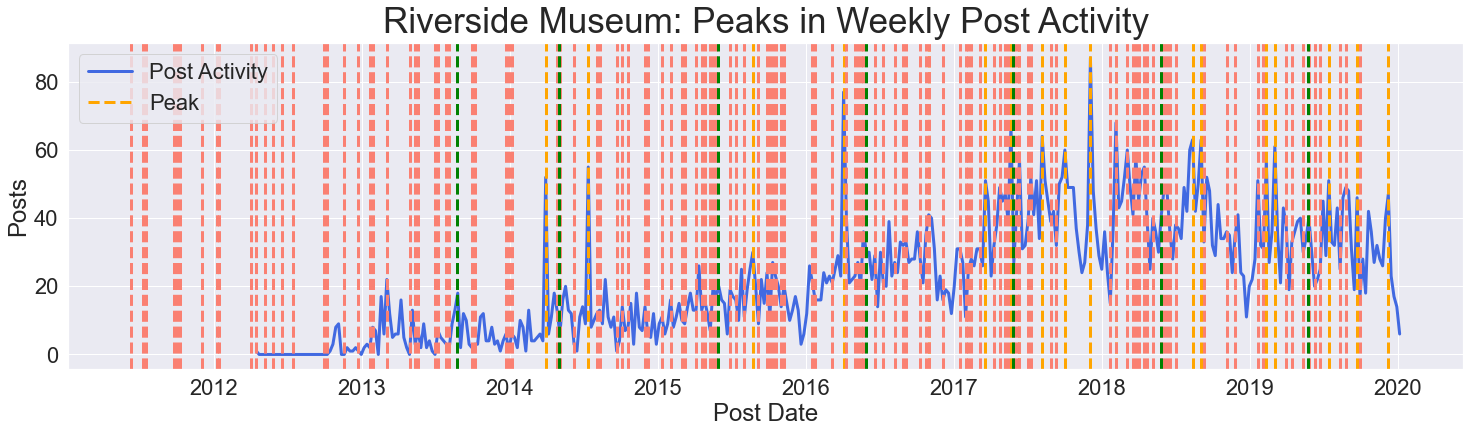

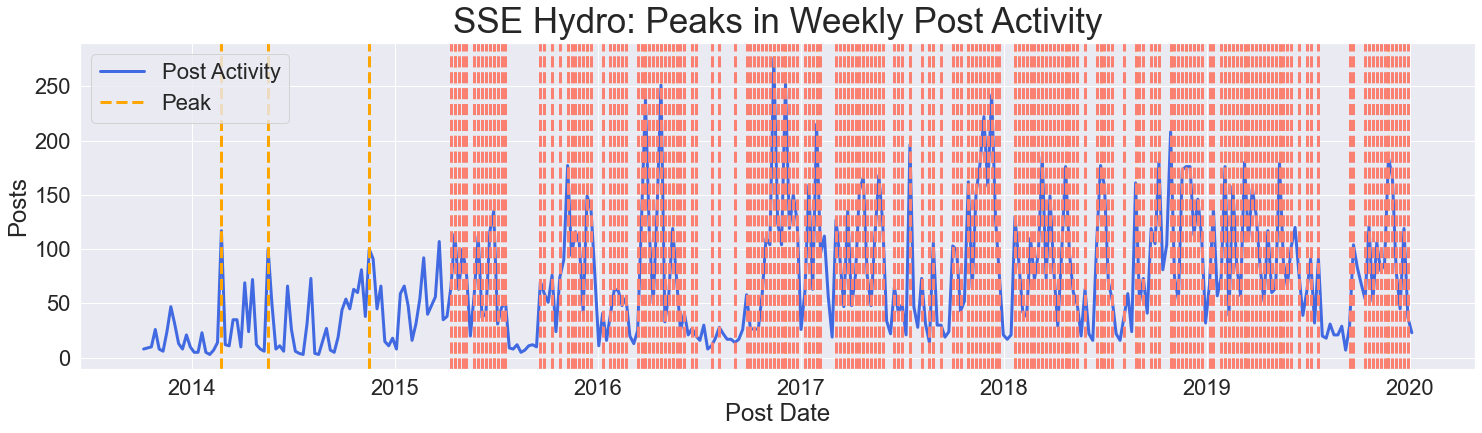

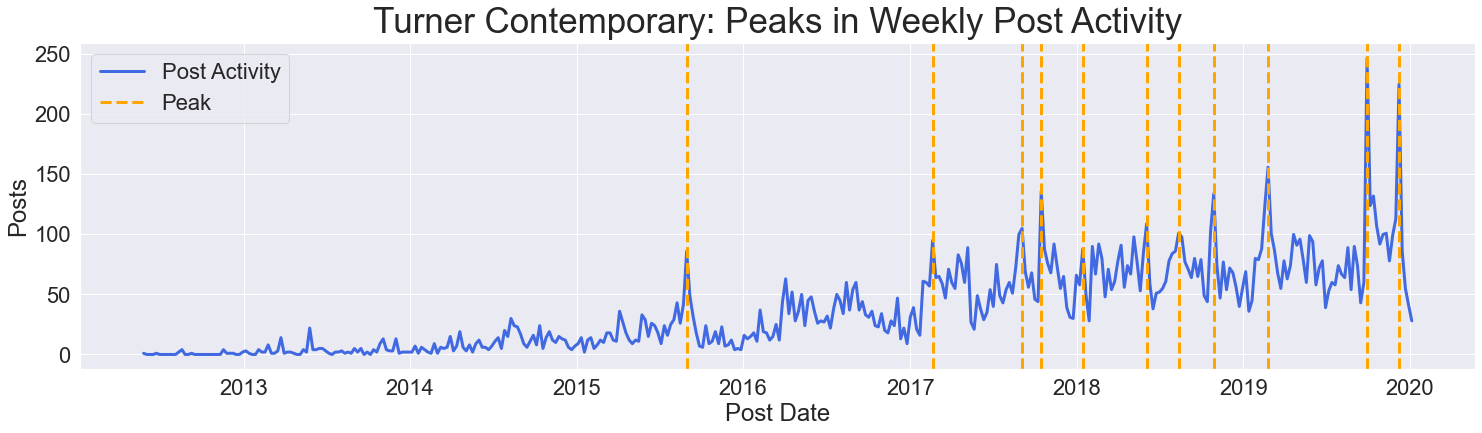

In [80]:
sns.set(rc={'figure.figsize': (25, 6)})
sns.set(font_scale=2)

for i, project in enumerate(data):

    # if project != "Messeplatz (Basel)":
    #     continue

    res = data[project]
    df = res["df"]
    df_events_programme = res["df_event1"]
    df_events_external = res["df_event2"]
    # using mean() for the rolling window here. median can also work but doesn't perform better than mean here (from looking at the plots vs. the automatically found spikes)
    # spikes = get_spike_weeks(df)

    grouped = df.groupby(pd.Grouper(freq="W")).count()["id"]
    spike_idxs = find_peaks(grouped, prominence=grouped.std() * 1.5)
    spikes = grouped.iloc[spike_idxs[0]]

    lines = [[spike_date, "orange"] for spike_date in spikes.index]

    # Get programme events
    if df_events_programme is not None:
        # Allow for a maximum of 1 event a week
        resample_freq = "W"
        # add dummy columns so we can aggreate dfs that just have an index and no data
        df_events_programme["dummy"] = "dummy"
        resampled = df_events_programme.groupby(pd.Grouper(freq=resample_freq)).count()
        resampled = resampled[resampled["dummy"] >= 1]

        lines += [[event_date, "salmon"] for event_date in resampled.index]
    # Get external events
    if df_events_external is not None:
        lines += [[event_date, "green"] for event_date in df_events_external.index]
    # Plot post activity, spikes and events

    # plot_post_activity_slider(df, line_dates=lines)
    plot_post_activity(df, line_dates=lines,
                       title="{}: Peaks in Weekly Post Activity".format(truncate_project(project)), title_fontsize=35)


In [81]:
def thresholding_algo(y, lag, threshold, influence):
    # https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/22640362#22640362
    # https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/43512887#43512887
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0] * len(y)
    stdFilter = [0] * len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i - 1]) > threshold * stdFilter[i - 1]:
            if y[i] > avgFilter[i - 1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i - 1]
            avgFilter[i] = np.mean(filteredY[(i - lag + 1):i + 1])
            stdFilter[i] = np.std(filteredY[(i - lag + 1):i + 1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i - lag + 1):i + 1])
            stdFilter[i] = np.std(filteredY[(i - lag + 1):i + 1])

    return dict(signals=np.asarray(signals),
                avgFilter=np.asarray(avgFilter),
                stdFilter=np.asarray(stdFilter))

### Spike Test: mean

In [82]:
# project ="Matmut Atlantique (Bordeaux)"
project = "Musikkens Hus (Aalborg)"
res = data[project]
df = res["df"]
df_events_programme = res["df_event1"]
df_events_external = res["df_event2"]
# using mean() for the rolling window here. median can also work but doesn't perform better than mean here (from looking at the plots vs. the automatically found spikes)
spikes = get_spikes(df, freq="W", window_size=9, threshold=2, min_posts=20, id_col="id", aggregate="mean")

lines = [[spike_date, "orange"] for spike_date in spikes.index]
plot_post_activity_slider(df, line_dates=lines)

### Spikes Test: scipy find_peaks
prominence paramter: https://stackoverflow.com/questions/1713335/peak-finding-algorithm-for-python-scipy
https://en.wikipedia.org/wiki/Topographic_prominence
does better job of eliminating 'double peaks' than rolling mean approach

In [83]:
grouped = df.groupby(pd.Grouper(freq="W")).count()["id"]
spike_idxs = find_peaks(grouped, prominence=grouped.mean() * 1.5)
spikes = grouped.iloc[spike_idxs[0]]
spikes
lines = [[spike_date, "orange"] for spike_date in spikes.index]
plot_post_activity_slider(df, line_dates=lines)

### Spike Test: Z-scores

In [84]:
grouped = df.groupby(pd.Grouper(freq="W")).count()["id"]
result = thresholding_algo(grouped, lag=3, influence=0.2, threshold=5)
spike_signals = result["signals"]
spike_idxs = np.where(spike_signals == 1)

spikes = grouped.iloc[spike_idxs[0]]
lines = [[spike_date, "orange"] for spike_date in spikes.index]
plot_post_activity_slider(df, line_dates=lines)

**Results: Non-programme events:**
- Elphi (Elbjazz): does not correlate wth spikes
- Hepworth (Fairs): correlates very closely with spikes
- Ragnarock (Roskilde estival): no correlation -> even though the festial is clearly visible in the Roskilde city graph (I assume it's the festival and not something else)
 -> but keep in mind that the festival is not actuall at the venue
- Riverside Museum (Riverside Festival): No correlation

## Events vs. Post Activity

In [85]:
def event_barplot(time_ser, event_time_ser, freq="D", window_size=15, title="", do_print=False,
                  ks_alternative="two-sided", ax=None, descriptor="peaks", tmp=False):
    """
    :param time_ser: list of posts: dataframe or series with datetime index
    :param event_ser: list of events: dataframe or series with datetime index
    :param window_size:
    :param do_print: print the results of the analysis
    :param ks_alternative: mode for the KS statistical test (two-sided/less/greater)
    """

    # construct dummy series (so we get rid of unknown columns) and group the data by some time frequency
    grp = pd.Series(data="dummy", index=time_ser.index).groupby(pd.Grouper(freq=freq)).count()
    # transform events to same time frequency as the main data
    grp_event = pd.Series(data="dummy", index=event_time_ser.index).groupby(pd.Grouper(freq=freq)).count()
    grp_event = grp_event[grp_event >= 1]

    counts = {}  # one bin per time step
    counts_simple = {-1: [], 0: [], 1: []}  # 3 bins for before, during and after the event
    # collect number of posts for each time step in the window (left and right of the event)
    # Example: window size = 5 ->  collect posts from day [-2, -1, 0, 1, 2] where 0 = the day of the event
    half_window = window_size // 2
    # iterate over events
    for event_date in grp_event.index:
        # make sure the event is inside the observation period
        if event_date in grp.index:
            # construct a window of time steps before,during and after the event
            for i in range(-half_window, half_window + 1):
                current_i = grp.index.get_loc(event_date) + i
                # make sure the index exists (i.e. window does not protrude the data)
                if current_i in range(0, len(grp)):
                    # get the count at this time step
                    count = grp.iloc[current_i]
                else:
                    count = np.NaN
                counts[i] = counts[i] + [count] if i in counts else [count]
                counts_simple[np.sign(i)] += [count]

    # Plot the results
    res = pd.DataFrame(counts)
    colors = {
        -1: "royalblue",
        0: "orange",
        1: "seagreen"
    }
    if ax is None:
        plt.figure()
        ax = sns.barplot(data=res, palette=[colors[np.sign(c)] for c in res.columns])
    else:
        sns.barplot(data=res, palette=[colors[np.sign(c)] for c in res.columns], ax=ax)
    ax.set_title(title, fontsize=25, pad=10)
    ax.set_ylabel("Mean Posts")
    xlabel = "Week" if freq == "W" else "Day"
    ax.set_xlabel(xlabel)

    # Statistical test of posts before vs. after
    posts_before, posts_during, posts_after = counts_simple[-1], counts_simple[0], counts_simple[1]
    statistic, p_value = mannwhitneyu(posts_after, posts_before, alternative=ks_alternative)
    if tmp:
        statistic, p_value = mannwhitneyu(posts_during, posts_before, alternative=ks_alternative)
    # Show the results in an info box
    textstr = "{}: {}\nbefore: {} \nduring: {} \nafter: {} \np-val: {}".format(descriptor, len(grp_event),
                                                                               np.nanmean(posts_before).round(1),
                                                                               np.nanmean(posts_during).round(1),
                                                                               np.nanmean(posts_after).round(1),
                                                                               np.round(p_value, 3))
    if do_print:
        print(textstr)
    props = dict(boxstyle='round', facecolor='grey', alpha=0.3)

    # eternal events: 0.00, 0.75+ no p-value shown
    # place a text box in upper left in axes coords
    ax.text(0.00, 1.35, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

### Programme Events: Daily Posts before, during and after the event across all events

Text(0.5, 1.0, 'Post Activity around Programme-related Events')

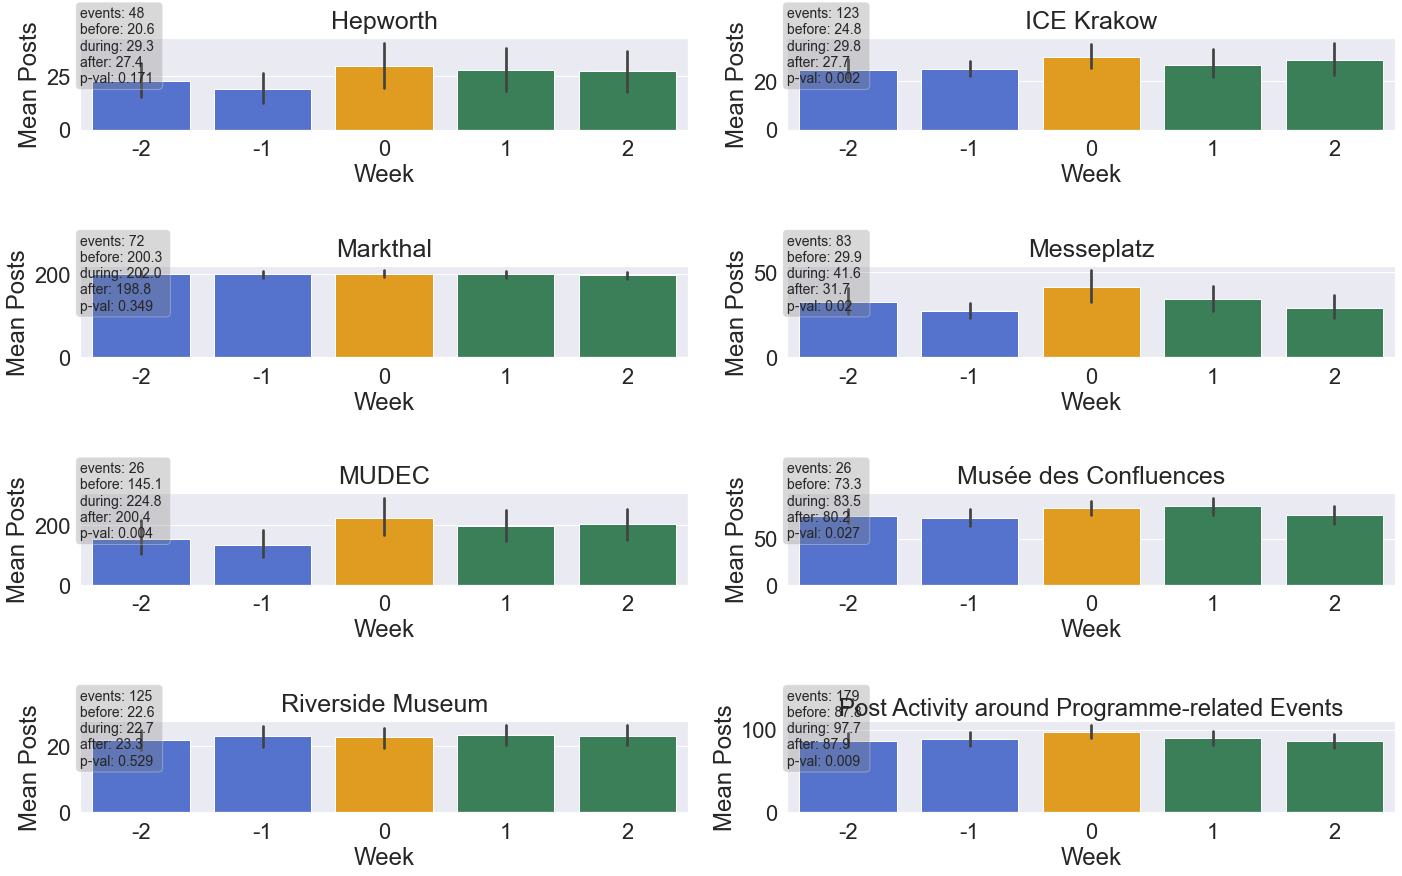

In [86]:
n_cols = 2
fig, axs = plt.subplots(4, n_cols, figsize=[20, 13])
i = 0
for project in data:
    res = data[project]
    df = res["df"]
    df_events = res["df_event1"]
    if df_events is not None:
        ax = axs[int(i / n_cols), i % n_cols]
        event_barplot(df, df_events, freq="W", window_size=5, title="{}".format(truncate_project(project)),
                      ks_alternative="greater", ax=ax, descriptor="events", tmp=True)
        i += 1
plt.tight_layout()
plt.title("Post Activity around Programme-related Events")

### Programme Events: Weekly Posts before, during and after the event across all events

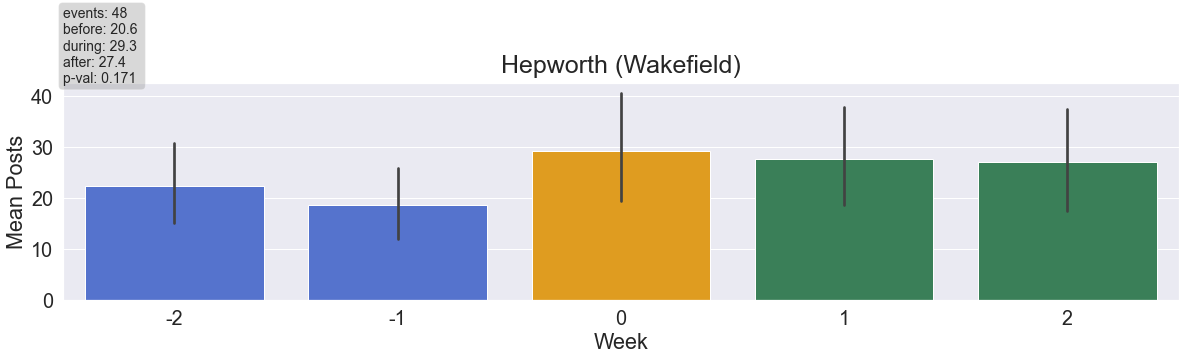

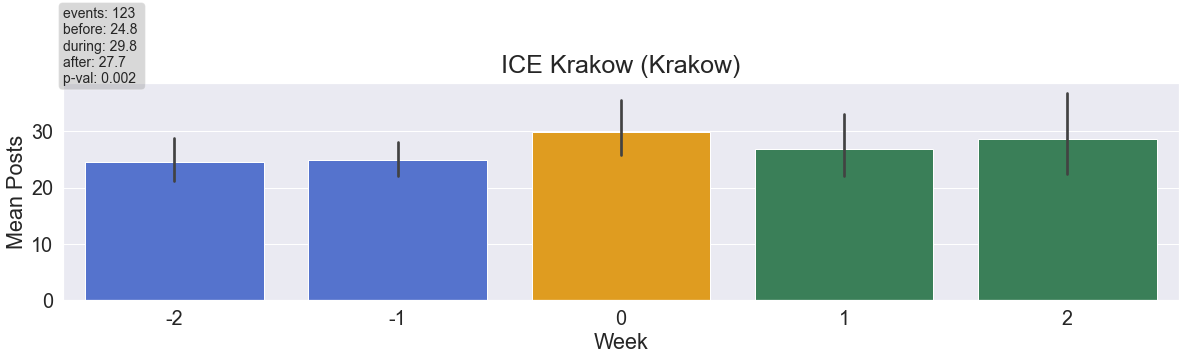

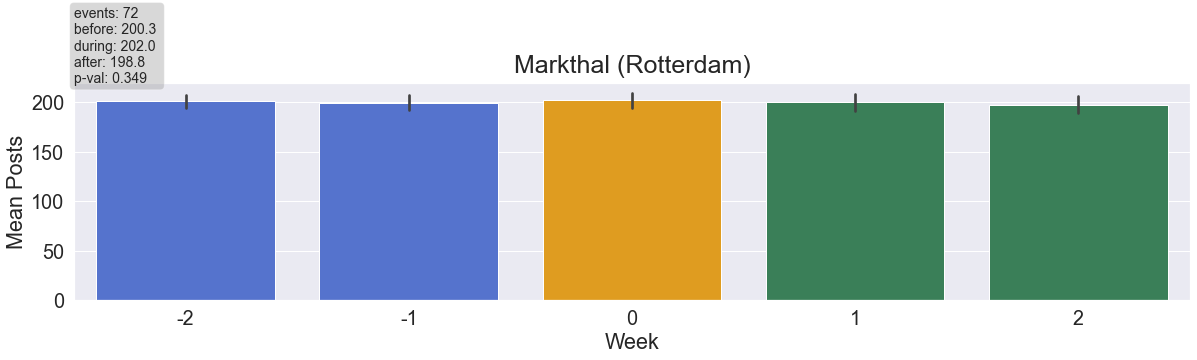

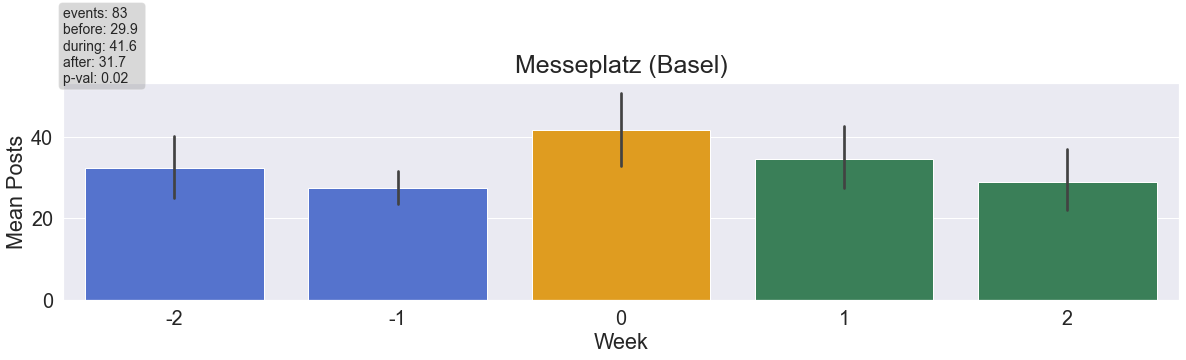

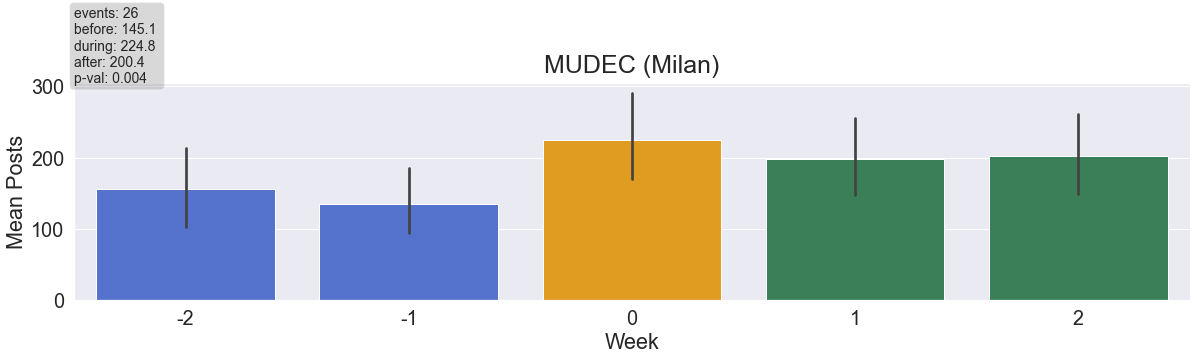

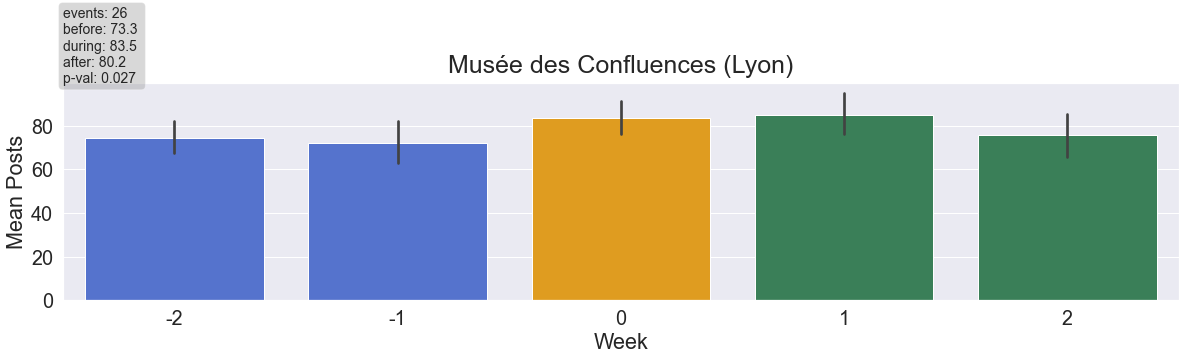

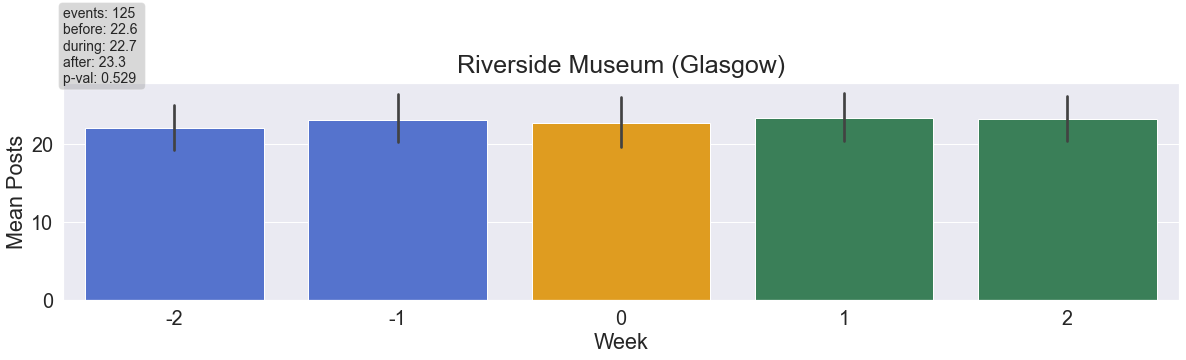

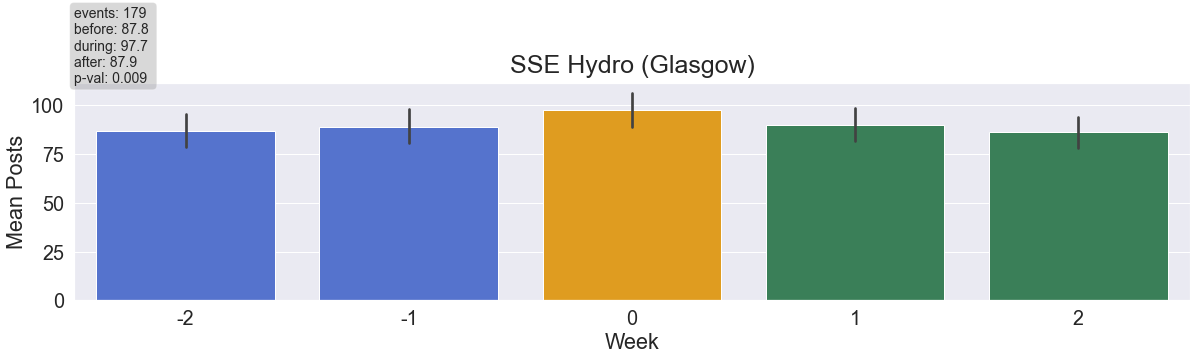

In [87]:
reset_layout()
for i, project in enumerate(data):
    res = data[project]
    df = res["df"]
    df_events = res["df_event1"]
    if df_events is not None:
        event_barplot(df, df_events, freq="W", window_size=5, title=project, ks_alternative="greater",
                      descriptor="events", ax=None, tmp=True)

**Results**
Programme events for
- museum: exhibition openings
- concert hall / event areas: events

Observations:
- museums: new exhibit generally increases the post activity during and after the opening (only exception is Riverside Museum)
- event spaces (ICE, SSE, Messeplatz.): ice: strong increase during the day and the next (maybe 2 events on consecutive day) but not long after that. Only exception is Messeplatz where the post acticity drops of more slowly

### External Events: Daily Posts before, during and after the event across all events
Elphi: Elbjazz festival
Hepworth Wakefield: Fairs
Ragnarock: Roskilde festival
Riverside Museum: Riverside Festival

### External Events: Daily Posts before, during and after the event across all events

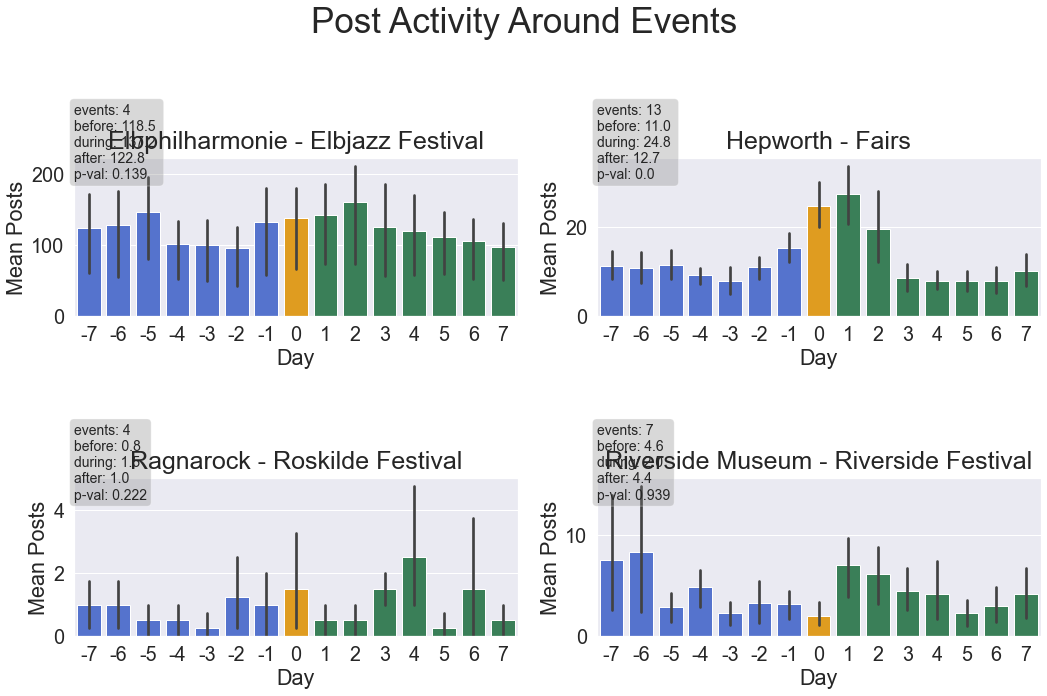

In [88]:
event_lookup = {
    "Elbphilharmonie (Hamburg)": "Elbjazz Festival",
    "Hepworth (Wakefield)": "Fairs",
    "Ragnarock (Roskilde)": "Roskilde Festival",
    "Riverside Museum (Glasgow)": "Riverside Festival"
}

n_cols = 2
fig, axs = plt.subplots(2, n_cols, figsize=[15, 10])
i = 0
for project in data:
    res = data[project]
    df = res["df"]
    df_events = res["df_event2"]
    if df_events is not None:
        ax = axs[int(i / n_cols), i % n_cols]
        event_name = event_lookup[project]
        event_barplot(df, df_events, freq="D", window_size=14,
                      title="{} - {}".format(truncate_project(project), event_name), ks_alternative="greater", ax=ax,
                      descriptor="events", tmp=True)
        i += 1
plt.suptitle("Post Activity Around Events", fontsize=35)
plt.tight_layout()


### Do spikes in post activity lead to increase post activity in the tie afterwards
Method:
- get spikes
- get project post activity (starting 1 month after the inauguration -> we'll analyze the inauguration spike separately)

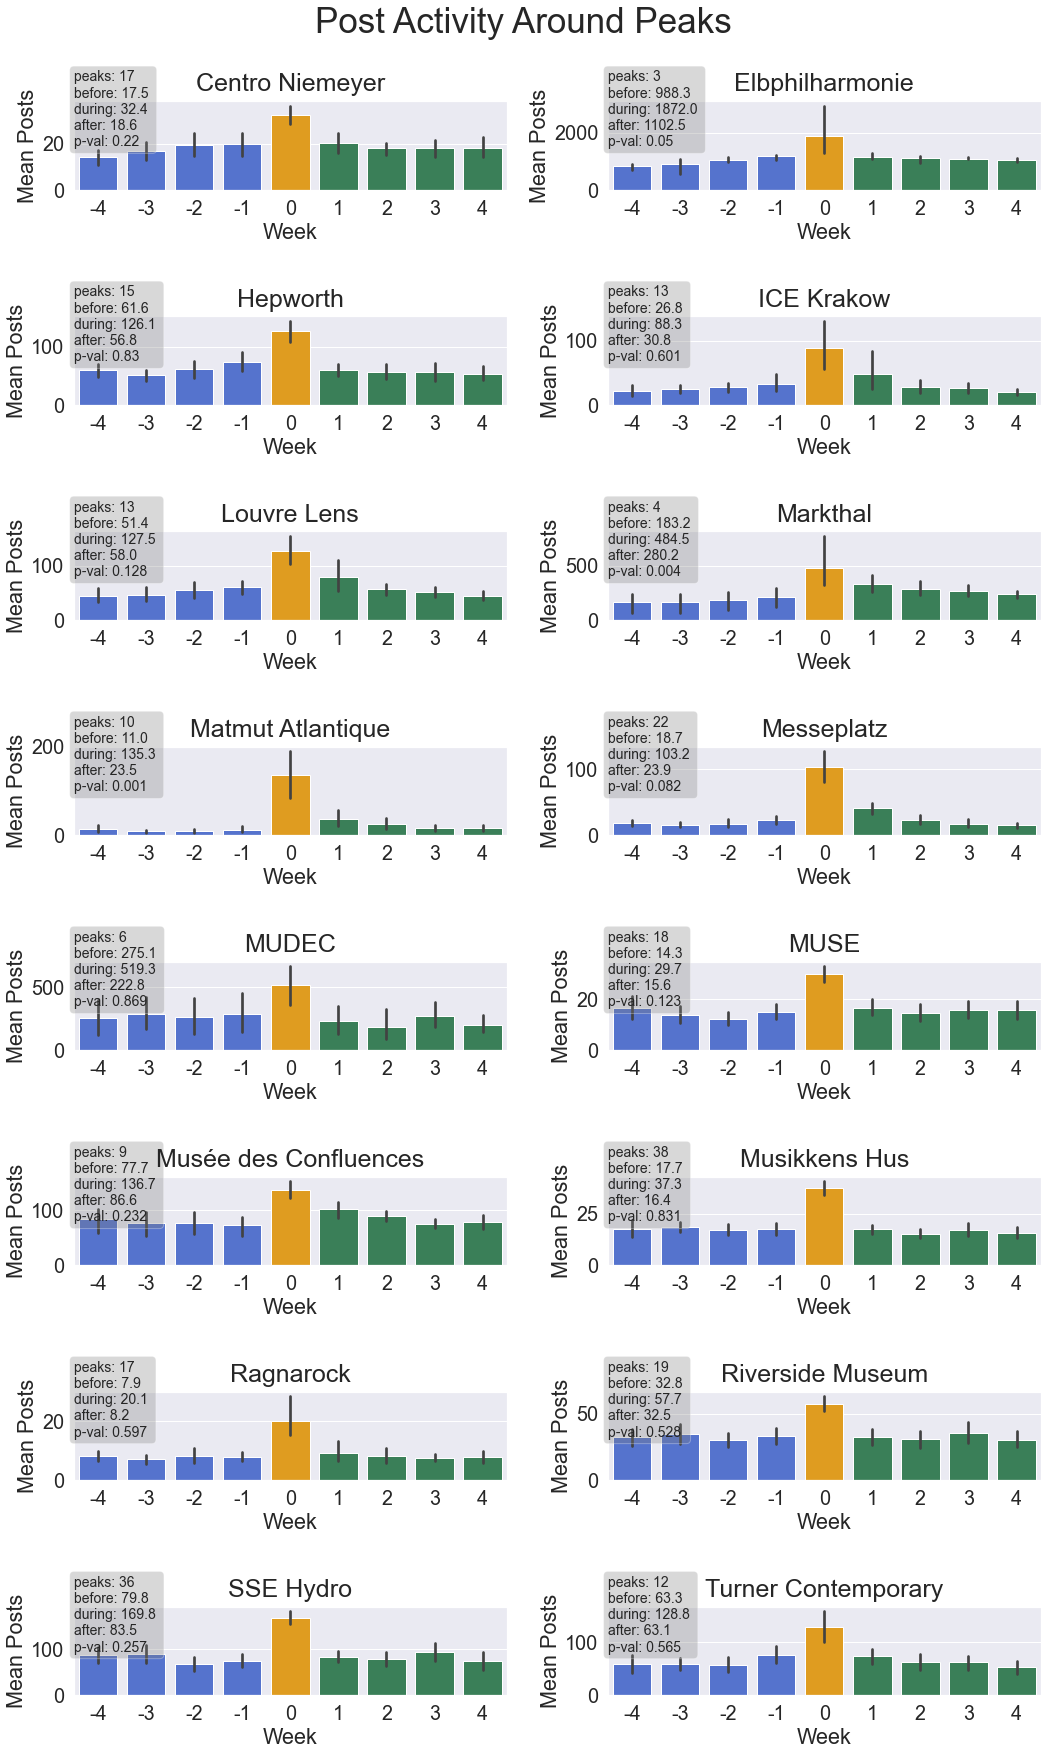

In [89]:
reset_layout()
n_cols = 2
fig, axs = plt.subplots(8, n_cols, figsize=[15, 25])

for i, project in enumerate(data):
    ax = axs[int(i / n_cols), i % n_cols]
    res = data[project]
    df = res["df"]
    # start observation period 1 month after the inauguration
    # opening = pd.to_datetime(res["opening"])
    # start_obs = opening + pd.DateOffset(months=1)
    # df_obs = df[df.index >= start_obs]

    # using mean() for the rolling window here. median can also work but doesn't perform better than mean here (from looking at the plots vs. the automatically found spikes)
    # spikes = get_spike_weeks(df_obs)

    grouped = df.groupby(pd.Grouper(freq="W")).count()["id"]
    spike_idxs = find_peaks(grouped, prominence=grouped.std() * 1.4)
    spikes = grouped.iloc[spike_idxs[0]]

    # spikes_distance = pd.Series(spikes.index).diff()
    # spikes_distance.std().days
    if len(spikes):
        event_barplot(df, spikes, freq="W", window_size=9, title="{}".format(truncate_project(project)),
                      ks_alternative="greater", ax=ax)
plt.suptitle("Post Activity Around Peaks", fontsize=35)
plt.tight_layout()


**Results**
In a 4-week (before and after) time window, **not a single project sees significantly more posts before _or_ after the spike** (compared to the respective other)

An observation:
For some projects (e.g. Centro Niemeyer, Hepworth, Louvre-Lens), the post activity seems to build up towards the spike and then slowly go back down afterwards. Not sure what that means.
Since all 3 are museums that could just be the natural behavior for when a new exhibition opens.